In [1]:
from __future__ import division
import os, time, pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import np_utils, get_custom_objects
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from utils import *
from ops import *


In [2]:
class PINE(object):
    model_name = "PINE"     # name for checkpoint

    def __init__(self, sess, epoch, batch_size, dataset_name, checkpoint_dir):
        self.sess = sess
        self.dataset_name = dataset_name
        self.checkpoint_dir = checkpoint_dir
        self.epoch = epoch
        self.batch_size = batch_size

        if dataset_name == 'mnist':
            # parameters
            self.input_height = 28
            self.input_width = 28
            self.output_height = 28
            self.output_width = 28
      
            self.y_dim = 10        
            self.c_dim = 1

            # train
            self.learning_rate = 0.0001
            self.beta1 = 0.5

            # test
            self.sample_num = 64  
            self.len_discrete_code = 10

            # load mnist
            self.data_X, self.data_y = load_mnist(self.dataset_name)

            # get number of batches for a single epoch
            self.num_batches = len(self.data_X) // self.batch_size
            self.kcc = tf.keras.losses.CategoricalCrossentropy()

        elif dataset_name == 'cifar10':
            # parameters
            self.input_height = 32
            self.input_width = 32
            self.output_height = 32
            self.output_width = 32
      
            self.y_dim = 10        
            self.c_dim = 3

            # Loss terms coefficients
            self.c1 = 10000
            self.c2 = 10000
            self.c3 = 1000000
            self.c4 = 1000
            # train
            self.learning_rate = 0.0001
            self.beta1 = 0.5

            # test
            self.sample_num = 64  

            # load mnist
            self.data_X, self.data_X_test, self.data_y, self.data_y_test = load_cifar10(self.dataset_name)

            # get number of batches for a single epoch
            self.num_batches = len(self.data_X) // self.batch_size
            self.kcc = tf.keras.losses.CategoricalCrossentropy()            
        else:
            raise NotImplementedError

        
#            ___________
#           /           \
#          / MAIN  MODEL \
#         /_______________\        


        
    def main_model(self, x, is_training=True, reuse=False):

        with tf.compat.v1.variable_scope("main_model", reuse=reuse):    

            net = lrelu(coinv2d(x, 64, 4, 4, 2, 2, name='mm_conv1'))
            net = lrelu(bn(coinv2d(net, 128, 4, 4, 2, 2, name='mm_conv2'), is_training=is_training, scope='mm_bn2'))
            net = tf.reshape(net, [self.batch_size, -1])
            net = lrelu(bn(linear(net, 1024, scope='mm_fc3'), is_training=is_training, scope='mm_bn3'))
            out_logit = linear(net, 10, scope='mm_fc4')
            out = tf.nn.softmax(out_logit)

            return out, out_logit
        
        
#          _________________
#          \               /
#           \             /
#            \           /
#             INTERPRETER
#            /           \
#           /             \
#          /_______________\
                

    def interpreter(self, x, is_training=True, reuse=False):
        
        with tf.compat.v1.variable_scope("interpreter", reuse=reuse):

            net = tf.nn.relu(coinv2d(x, 64, 4, 4, 2, 2, name='int_conv1'))
            net = tf.reshape(net, [self.batch_size, -1])
            code = (linear(net, 32, scope='int_fc6')) # bn and relu are excluded since code is used in pullaway_loss
            net = tf.nn.relu(bn(linear(code, 64 * 14 * 14, scope='int_fc3'), is_training=is_training, scope='int_bn3'))
            net = tf.reshape(net, [self.batch_size, 14, 14, 64])
            out = tf.nn.sigmoid(deconv2d(net, [self.batch_size, 28, 28, 1], 4, 4, 2, 2, name='int_dc5'))

            # recon loss
            recon_error = tf.sqrt(2 * tf.nn.l2_loss(out - x)) / self.batch_size
            return out, recon_error, code

        
    def build_pine(self):
        # some parameters
        image_dims = [self.input_height, self.input_width, self.c_dim]
        bs = self.batch_size

        """ Graph Input """
        # images
        self.inputs = tf.compat.v1.placeholder(tf.float32, [bs] + image_dims, name='real_images')

        # labels
        self.y = tf.compat.v1.placeholder(tf.float32, [bs, self.y_dim], name='y')


        """ Loss Function """


        tafsir, tafsir_err, code = self.interpreter(self.inputs, is_training=True)
        out_tafsir, out_logit_tafsir = self.main_model(tafsir, is_training=True)
        out_real, out_logit_real = self.main_model(self.inputs, is_training=True, reuse= True)        



        self.mm_loss = self.kcc(out_real,self.y)
        out_sqrt = tf.keras.backend.sqrt(tafsir)
        sumi = tf.keras.backend.sum(out_sqrt)**2
        self.int_loss = 10000*tafsir_err + 10000*self.kcc(out_tafsir, self.y) + sumi / 1000000 


        """ Training """

        t_vars = tf.compat.v1.trainable_variables()
        int_vars = [var for var in t_vars if 'int_' in var.name]
        mm_vars = [var for var in t_vars if 'mm_' in var.name]
  

        # optimizers
        with tf.control_dependencies(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)):

            self.int_optim = tf.compat.v1.train.AdamOptimizer(self.learning_rate * 5, beta1=self.beta1) \
            .minimize(self.int_loss, var_list=int_vars)
            self.mm_optim = tf.compat.v1.train.AdamOptimizer(self.learning_rate * 5, beta1=self.beta1) \
            .minimize(self.mm_loss, var_list=mm_vars)


        """" Testing """
        # for test
        self.tafsir_images = self.interpreter(self.inputs, is_training=False, reuse=True)
        """ Summary """
        int_loss_sum = tf.compat.v1.summary.scalar("int_loss", self.int_loss)
        mm_loss_sum = tf.compat.v1.summary.scalar("mm_loss", self.mm_loss)

        self.int_sum = tf.compat.v1.summary.merge([int_loss_sum])
        self.mm_sum = tf.compat.v1.summary.merge([mm_loss_sum])
        #################################################### 
        #                                ________________  #
        #    ___________                \               /  #
        #   /           \    Parallel    \             /   #
        #  / MAIN  MODEL \      ||        \           /    #
        # /_______________\  Training      INTERPRETER     #
        #                                 /           \    #
        #                                /             \   #
        #                               /_______________\  #
        ####################################################           
    def train(self):

        # initialize all variables
        tf.compat.v1.global_variables_initializer().run()

        # graph inputs for visualize training results
        self.test_codes = self.data_y[0:self.batch_size]
        self.sample_input = self.data_X[0:self.batch_size]

        # saver to save model
        self.saver = tf.compat.v1.train.Saver()

        # restore check-point if it exits
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        if could_load:
            start_epoch = (int)(checkpoint_counter / self.num_batches)
            start_batch_id = checkpoint_counter - start_epoch * self.num_batches
            counter = checkpoint_counter
            print(" [i] OK. I've found it.")
        else:
            start_epoch = 0
            start_batch_id = 0
            counter = 1
            print(" [i] NOTHING FOUND TO LOAD!")

        # loop for epoch
        start_time = time.time()
        for epoch in range(start_epoch, self.epoch):

            # get batch data
            for idx in range(start_batch_id, self.num_batches):
                batch_images = self.data_X[idx*self.batch_size:(idx+1)*self.batch_size]
                batch_codes = self.data_y[idx * self.batch_size:(idx + 1) * self.batch_size]


                #update Interpreter
                _, summary_str, int_loss = self.sess.run([self.int_optim, self.int_sum, self.int_loss],
                                                       feed_dict={self.inputs: batch_images, self.y: batch_codes})

                # update Main Model
                _, summary_str_mm, mm_loss = self.sess.run(
                    [self.mm_optim, self.mm_sum, self.mm_loss],
                    feed_dict={self.y: batch_codes, self.inputs: batch_images})


                # display training status
                counter += 1
                print("Epoch: [%2d] [%4d/%4d] time: %4.4f, int_loss: %.8f,mm_loss: %.8f" \
                      % (epoch, idx, self.num_batches, time.time() - start_time, int_loss, mm_loss))


            start_batch_id = 0

            # save model
            self.save(self.checkpoint_dir, counter)

        # save model for final step
        self.save(self.checkpoint_dir, counter)

    @property
    def model_dir(self):
        return "{}_{}".format(
            self.model_name, self.dataset_name)

    def save(self, checkpoint_dir, step):
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir, self.model_name)

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        self.saver.save(self.sess,os.path.join(checkpoint_dir, self.model_name+'.model'), global_step=step)

    def load(self, checkpoint_dir):
        import re
        print(" [i] Wait a sec...")
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir, self.model_name)

        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            counter = int(next(re.finditer("(\d+)(?!.*\d)",ckpt_name)).group(0))
            print(" [i] OK. Reading Completed! {}".format(ckpt_name))
            return True, counter
        else:
            print(" [i] NO CHECKPOINTS FOUND!")
            return False, 0
    def just_load(self, tobe_tafsired):
        
        # initialize all variables
        tf.compat.v1.global_variables_initializer().run()

        # graph inputs for visualize training results
        self.test_codes = self.data_y[0:self.batch_size]
        self.sample_input = self.data_X[0:self.batch_size]


        # saver to save model
        self.saver = tf.compat.v1.train.Saver()


        # restore check-point if it exits
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        if could_load:
            start_epoch = (int)(checkpoint_counter / self.num_batches)
            start_batch_id = checkpoint_counter - start_epoch * self.num_batches
            counter = checkpoint_counter
            print(" [i] Loading done!")
        samples, recon_error, code = self.sess.run(self.tafsir_images, feed_dict={self.inputs: tobe_tafsired})
        return samples
    

In [3]:
samples = []
X_test = pd.read_csv("test.csv")
X_test = X_test/255
X_test = X_test.values.reshape(-1,28,28,1)
tests = X_test[0:64]
with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True)) as sess:
# open session
    pine = PINE(sess,
                epoch=5,
                batch_size=64,
                dataset_name='mnist',
                checkpoint_dir= 'checkpoint')

    # build graph
    pine.build_pine()
    # initialize all variables
    pine.train()
    interprets = pine.just_load(tests)

Metal device set to: Apple M2


2023-02-25 17:43:37.173247: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-25 17:43:37.173284: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Instructions for updating:
Colocations handled automatically by placer.


/Users/narimanarian/Documents/GitHub/pine/notebooks/PINE (TF 1x Compatible)/ops.py:20: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  return tf.compat.v1.layers.batch_normalization(x,
2023-02-25 17:43:38.295295: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-02-25 17:43:38.311243: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-25 17:43:38.319536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 [i] Wait a sec...
 [i] NO CHECKPOINTS FOUND!
 [i] NOTHING FOUND TO LOAD!


2023-02-25 17:43:39.289149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-25 17:43:46.760353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch: [ 0] [   0/1093] time: 8.5185, int_loss: 3291373.75000000,mm_loss: 14.46765137
Epoch: [ 0] [   1/1093] time: 8.5913, int_loss: 3111777.75000000,mm_loss: 10.37761307
Epoch: [ 0] [   2/1093] time: 8.6359, int_loss: 3064061.00000000,mm_loss: 7.98776436
Epoch: [ 0] [   3/1093] time: 8.6973, int_loss: 3142017.50000000,mm_loss: 7.61030626
Epoch: [ 0] [   4/1093] time: 8.7439, int_loss: 3168869.00000000,mm_loss: 6.48972034
Epoch: [ 0] [   5/1093] time: 8.7960, int_loss: 2994466.00000000,mm_loss: 4.08062506
Epoch: [ 0] [   6/1093] time: 8.8479, int_loss: 3109951.75000000,mm_loss: 4.46486473
Epoch: [ 0] [   7/1093] time: 8.9063, int_loss: 2966181.75000000,mm_loss: 3.59562922
Epoch: [ 0] [   8/1093] time: 8.9666, int_loss: 3007444.00000000,mm_loss: 3.58665085
Epoch: [ 0] [   9/1093] time: 9.0690, int_loss: 3086924.25000000,mm_loss: 3.25158310
Epoch: [ 0] [  10/1093] time: 9.2310, int_loss: 3036391.50000000,mm_loss: 4.23258495
Epoch: [ 0] [  11/1093] time: 9.3330, int_loss: 2975224.5000000

Epoch: [ 0] [  99/1093] time: 15.3595, int_loss: 2973319.00000000,mm_loss: 1.16281736
Epoch: [ 0] [ 100/1093] time: 15.4315, int_loss: 2971159.50000000,mm_loss: 0.94416952
Epoch: [ 0] [ 101/1093] time: 15.5001, int_loss: 3003314.50000000,mm_loss: 1.10353780
Epoch: [ 0] [ 102/1093] time: 15.5658, int_loss: 3046662.00000000,mm_loss: 1.91649032
Epoch: [ 0] [ 103/1093] time: 15.6328, int_loss: 2871466.00000000,mm_loss: 2.10809970
Epoch: [ 0] [ 104/1093] time: 15.7096, int_loss: 2969943.25000000,mm_loss: 1.72548509
Epoch: [ 0] [ 105/1093] time: 15.8223, int_loss: 3147949.00000000,mm_loss: 0.77093190
Epoch: [ 0] [ 106/1093] time: 15.9252, int_loss: 2984399.00000000,mm_loss: 0.36354637
Epoch: [ 0] [ 107/1093] time: 16.0179, int_loss: 2935369.75000000,mm_loss: 1.16993189
Epoch: [ 0] [ 108/1093] time: 16.1080, int_loss: 3000529.00000000,mm_loss: 0.52431953
Epoch: [ 0] [ 109/1093] time: 16.1912, int_loss: 2956917.75000000,mm_loss: 1.08460677
Epoch: [ 0] [ 110/1093] time: 16.2701, int_loss: 29546

Epoch: [ 0] [ 197/1093] time: 22.4144, int_loss: 3062977.75000000,mm_loss: 0.50490534
Epoch: [ 0] [ 198/1093] time: 22.4808, int_loss: 2903977.50000000,mm_loss: 0.23628718
Epoch: [ 0] [ 199/1093] time: 22.5451, int_loss: 2936132.25000000,mm_loss: 1.49206734
Epoch: [ 0] [ 200/1093] time: 22.6128, int_loss: 3007468.25000000,mm_loss: 0.59278494
Epoch: [ 0] [ 201/1093] time: 22.6801, int_loss: 3025585.00000000,mm_loss: 0.60718155
Epoch: [ 0] [ 202/1093] time: 22.7457, int_loss: 2841640.75000000,mm_loss: 1.33333671
Epoch: [ 0] [ 203/1093] time: 22.8084, int_loss: 3047088.25000000,mm_loss: 0.91717386
Epoch: [ 0] [ 204/1093] time: 22.8686, int_loss: 3014304.50000000,mm_loss: 0.54174197
Epoch: [ 0] [ 205/1093] time: 22.9328, int_loss: 2962277.50000000,mm_loss: 0.06729273
Epoch: [ 0] [ 206/1093] time: 22.9971, int_loss: 2998959.00000000,mm_loss: 0.67356348
Epoch: [ 0] [ 207/1093] time: 23.0605, int_loss: 2968326.50000000,mm_loss: 2.10756874
Epoch: [ 0] [ 208/1093] time: 23.1268, int_loss: 29900

Epoch: [ 0] [ 296/1093] time: 29.3171, int_loss: 2929524.25000000,mm_loss: 0.75245261
Epoch: [ 0] [ 297/1093] time: 29.3810, int_loss: 3090091.25000000,mm_loss: 0.53667402
Epoch: [ 0] [ 298/1093] time: 29.4428, int_loss: 2921681.50000000,mm_loss: 1.59078741
Epoch: [ 0] [ 299/1093] time: 29.5047, int_loss: 2924611.25000000,mm_loss: 0.65522528
Epoch: [ 0] [ 300/1093] time: 29.5673, int_loss: 2991546.50000000,mm_loss: 0.30928689
Epoch: [ 0] [ 301/1093] time: 29.6295, int_loss: 2980224.50000000,mm_loss: 0.65492469
Epoch: [ 0] [ 302/1093] time: 29.6885, int_loss: 3003505.75000000,mm_loss: 0.56640363
Epoch: [ 0] [ 303/1093] time: 29.7490, int_loss: 2853014.75000000,mm_loss: 0.86362863
Epoch: [ 0] [ 304/1093] time: 29.8102, int_loss: 3064576.75000000,mm_loss: 0.34330511
Epoch: [ 0] [ 305/1093] time: 29.8693, int_loss: 3024922.50000000,mm_loss: 0.50455767
Epoch: [ 0] [ 306/1093] time: 29.9311, int_loss: 2993207.75000000,mm_loss: 0.06485851
Epoch: [ 0] [ 307/1093] time: 29.9915, int_loss: 30134

Epoch: [ 0] [ 393/1093] time: 35.3820, int_loss: 2975570.25000000,mm_loss: 0.31439039
Epoch: [ 0] [ 394/1093] time: 35.4510, int_loss: 2970432.00000000,mm_loss: 0.35282773
Epoch: [ 0] [ 395/1093] time: 35.5206, int_loss: 2933920.25000000,mm_loss: 1.06791735
Epoch: [ 0] [ 396/1093] time: 35.5880, int_loss: 3006104.25000000,mm_loss: 0.76254094
Epoch: [ 0] [ 397/1093] time: 35.6613, int_loss: 2966592.50000000,mm_loss: 0.59202069
Epoch: [ 0] [ 398/1093] time: 35.7310, int_loss: 2929852.75000000,mm_loss: 0.52918690
Epoch: [ 0] [ 399/1093] time: 35.8021, int_loss: 3024062.50000000,mm_loss: 0.31890690
Epoch: [ 0] [ 400/1093] time: 35.8730, int_loss: 3032526.75000000,mm_loss: 0.16766107
Epoch: [ 0] [ 401/1093] time: 35.9426, int_loss: 2996752.00000000,mm_loss: 0.40333068
Epoch: [ 0] [ 402/1093] time: 36.0133, int_loss: 2995420.00000000,mm_loss: 0.90639651
Epoch: [ 0] [ 403/1093] time: 36.0832, int_loss: 3098110.50000000,mm_loss: 0.57649875
Epoch: [ 0] [ 404/1093] time: 36.1539, int_loss: 30193

Epoch: [ 0] [ 489/1093] time: 42.1940, int_loss: 2924582.00000000,mm_loss: 0.78068155
Epoch: [ 0] [ 490/1093] time: 42.2651, int_loss: 2995480.50000000,mm_loss: 0.15565102
Epoch: [ 0] [ 491/1093] time: 42.3328, int_loss: 2997342.25000000,mm_loss: 0.84499788
Epoch: [ 0] [ 492/1093] time: 42.4000, int_loss: 2858504.50000000,mm_loss: 0.88055593
Epoch: [ 0] [ 493/1093] time: 42.4668, int_loss: 2888241.00000000,mm_loss: 0.46958292
Epoch: [ 0] [ 494/1093] time: 42.5313, int_loss: 3017042.25000000,mm_loss: 0.35110492
Epoch: [ 0] [ 495/1093] time: 42.5950, int_loss: 3057680.25000000,mm_loss: 0.05389962
Epoch: [ 0] [ 496/1093] time: 42.6582, int_loss: 2997241.75000000,mm_loss: 1.07245433
Epoch: [ 0] [ 497/1093] time: 42.7279, int_loss: 3014927.75000000,mm_loss: 0.61921662
Epoch: [ 0] [ 498/1093] time: 42.7945, int_loss: 2978636.00000000,mm_loss: 0.46668842
Epoch: [ 0] [ 499/1093] time: 42.8965, int_loss: 2971942.50000000,mm_loss: 0.12577952
Epoch: [ 0] [ 500/1093] time: 42.9972, int_loss: 30622

Epoch: [ 0] [ 586/1093] time: 49.0010, int_loss: 2976007.25000000,mm_loss: 0.78770894
Epoch: [ 0] [ 587/1093] time: 49.0703, int_loss: 2961363.50000000,mm_loss: 0.66533077
Epoch: [ 0] [ 588/1093] time: 49.1463, int_loss: 2960565.75000000,mm_loss: 0.10580639
Epoch: [ 0] [ 589/1093] time: 49.2240, int_loss: 3047321.00000000,mm_loss: 0.55872792
Epoch: [ 0] [ 590/1093] time: 49.2977, int_loss: 2953436.00000000,mm_loss: 0.22833088
Epoch: [ 0] [ 591/1093] time: 49.3676, int_loss: 2990707.50000000,mm_loss: 0.88794863
Epoch: [ 0] [ 592/1093] time: 49.4347, int_loss: 3039784.25000000,mm_loss: 0.02794739
Epoch: [ 0] [ 593/1093] time: 49.5013, int_loss: 2936593.75000000,mm_loss: 0.29307401
Epoch: [ 0] [ 594/1093] time: 49.5667, int_loss: 2865604.00000000,mm_loss: 0.87478364
Epoch: [ 0] [ 595/1093] time: 49.6310, int_loss: 2939953.00000000,mm_loss: 0.47180569
Epoch: [ 0] [ 596/1093] time: 49.6941, int_loss: 2984664.00000000,mm_loss: 0.37619936
Epoch: [ 0] [ 597/1093] time: 49.7543, int_loss: 30464

Epoch: [ 0] [ 682/1093] time: 55.5391, int_loss: 3055747.25000000,mm_loss: 0.27884081
Epoch: [ 0] [ 683/1093] time: 55.6042, int_loss: 3013244.75000000,mm_loss: 0.15190630
Epoch: [ 0] [ 684/1093] time: 55.6687, int_loss: 2961472.00000000,mm_loss: 0.52847731
Epoch: [ 0] [ 685/1093] time: 55.7374, int_loss: 2956411.00000000,mm_loss: 0.53073704
Epoch: [ 0] [ 686/1093] time: 55.8044, int_loss: 2907870.25000000,mm_loss: 0.27006748
Epoch: [ 0] [ 687/1093] time: 55.8705, int_loss: 2947757.00000000,mm_loss: 1.20626831
Epoch: [ 0] [ 688/1093] time: 55.9349, int_loss: 2991378.00000000,mm_loss: 0.25328612
Epoch: [ 0] [ 689/1093] time: 55.9993, int_loss: 3005168.50000000,mm_loss: 0.64387810
Epoch: [ 0] [ 690/1093] time: 56.0626, int_loss: 2982814.75000000,mm_loss: 0.26860037
Epoch: [ 0] [ 691/1093] time: 56.1288, int_loss: 2999477.50000000,mm_loss: 0.32454804
Epoch: [ 0] [ 692/1093] time: 56.1952, int_loss: 2961015.50000000,mm_loss: 0.54297376
Epoch: [ 0] [ 693/1093] time: 56.2621, int_loss: 31512

Epoch: [ 0] [ 780/1093] time: 62.2742, int_loss: 2958413.75000000,mm_loss: 0.39315507
Epoch: [ 0] [ 781/1093] time: 62.3354, int_loss: 3077640.00000000,mm_loss: 0.53240281
Epoch: [ 0] [ 782/1093] time: 62.3995, int_loss: 3039613.50000000,mm_loss: 0.48761132
Epoch: [ 0] [ 783/1093] time: 62.4649, int_loss: 2990439.25000000,mm_loss: 1.33406317
Epoch: [ 0] [ 784/1093] time: 62.5287, int_loss: 3079789.75000000,mm_loss: 0.73121411
Epoch: [ 0] [ 785/1093] time: 62.5916, int_loss: 2953727.25000000,mm_loss: 0.20691656
Epoch: [ 0] [ 786/1093] time: 62.6515, int_loss: 3007914.25000000,mm_loss: 0.42103785
Epoch: [ 0] [ 787/1093] time: 62.7169, int_loss: 2969111.25000000,mm_loss: 1.03168929
Epoch: [ 0] [ 788/1093] time: 62.7790, int_loss: 2955589.00000000,mm_loss: 0.33827946
Epoch: [ 0] [ 789/1093] time: 62.8385, int_loss: 3087811.75000000,mm_loss: 0.16084801
Epoch: [ 0] [ 790/1093] time: 62.8970, int_loss: 2991805.00000000,mm_loss: 0.71464562
Epoch: [ 0] [ 791/1093] time: 62.9537, int_loss: 30431

Epoch: [ 0] [ 876/1093] time: 68.4732, int_loss: 3095607.25000000,mm_loss: 0.23198378
Epoch: [ 0] [ 877/1093] time: 68.5367, int_loss: 2912686.75000000,mm_loss: 0.19875532
Epoch: [ 0] [ 878/1093] time: 68.6018, int_loss: 3050285.75000000,mm_loss: 0.32119241
Epoch: [ 0] [ 879/1093] time: 68.6719, int_loss: 2990468.25000000,mm_loss: 0.33026016
Epoch: [ 0] [ 880/1093] time: 68.7455, int_loss: 2963451.00000000,mm_loss: 0.67383713
Epoch: [ 0] [ 881/1093] time: 68.8207, int_loss: 2993533.25000000,mm_loss: 0.15555550
Epoch: [ 0] [ 882/1093] time: 68.8933, int_loss: 2904563.00000000,mm_loss: 0.48764074
Epoch: [ 0] [ 883/1093] time: 68.9674, int_loss: 2857578.00000000,mm_loss: 0.35231578
Epoch: [ 0] [ 884/1093] time: 69.0458, int_loss: 3014286.00000000,mm_loss: 0.25971985
Epoch: [ 0] [ 885/1093] time: 69.1222, int_loss: 2990302.25000000,mm_loss: 0.22783372
Epoch: [ 0] [ 886/1093] time: 69.1983, int_loss: 2971378.75000000,mm_loss: 0.51969516
Epoch: [ 0] [ 887/1093] time: 69.2716, int_loss: 29976

Epoch: [ 0] [ 974/1093] time: 75.2995, int_loss: 2976758.00000000,mm_loss: 0.40989998
Epoch: [ 0] [ 975/1093] time: 75.3737, int_loss: 2929219.00000000,mm_loss: 0.45881212
Epoch: [ 0] [ 976/1093] time: 75.4449, int_loss: 2941656.00000000,mm_loss: 0.65647364
Epoch: [ 0] [ 977/1093] time: 75.5144, int_loss: 3052360.25000000,mm_loss: 0.40165800
Epoch: [ 0] [ 978/1093] time: 75.5824, int_loss: 3050917.75000000,mm_loss: 0.50071394
Epoch: [ 0] [ 979/1093] time: 75.6549, int_loss: 3036297.00000000,mm_loss: 0.44872102
Epoch: [ 0] [ 980/1093] time: 75.7476, int_loss: 3065806.75000000,mm_loss: 0.53551424
Epoch: [ 0] [ 981/1093] time: 75.8413, int_loss: 2962985.50000000,mm_loss: 0.29337668
Epoch: [ 0] [ 982/1093] time: 75.9220, int_loss: 3010352.00000000,mm_loss: 0.55032772
Epoch: [ 0] [ 983/1093] time: 75.9943, int_loss: 2967295.50000000,mm_loss: 0.13940932
Epoch: [ 0] [ 984/1093] time: 76.0615, int_loss: 2889677.50000000,mm_loss: 0.91596359
Epoch: [ 0] [ 985/1093] time: 76.1262, int_loss: 29439

Epoch: [ 0] [1072/1093] time: 82.1248, int_loss: 2864739.75000000,mm_loss: 0.53987586
Epoch: [ 0] [1073/1093] time: 82.1908, int_loss: 2903728.75000000,mm_loss: 0.52204931
Epoch: [ 0] [1074/1093] time: 82.2569, int_loss: 3034589.50000000,mm_loss: 1.01168919
Epoch: [ 0] [1075/1093] time: 82.3327, int_loss: 2939998.25000000,mm_loss: 1.34486699
Epoch: [ 0] [1076/1093] time: 82.4088, int_loss: 2919830.50000000,mm_loss: 0.40094951
Epoch: [ 0] [1077/1093] time: 82.4825, int_loss: 3063887.25000000,mm_loss: 0.62372214
Epoch: [ 0] [1078/1093] time: 82.5511, int_loss: 3026948.00000000,mm_loss: 0.34043461
Epoch: [ 0] [1079/1093] time: 82.6169, int_loss: 2999889.75000000,mm_loss: 0.09376553
Epoch: [ 0] [1080/1093] time: 82.6812, int_loss: 2943598.00000000,mm_loss: 0.95511627
Epoch: [ 0] [1081/1093] time: 82.7467, int_loss: 2980831.00000000,mm_loss: 0.35753104
Epoch: [ 0] [1082/1093] time: 82.8096, int_loss: 3070812.50000000,mm_loss: 0.47026867
Epoch: [ 0] [1083/1093] time: 82.8721, int_loss: 28991

2023-02-25 17:45:02.756071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch: [ 1] [   0/1093] time: 84.6665, int_loss: 3147604.75000000,mm_loss: 0.09494109
Epoch: [ 1] [   1/1093] time: 84.7074, int_loss: 2981687.25000000,mm_loss: 0.51479757
Epoch: [ 1] [   2/1093] time: 84.7449, int_loss: 2946971.00000000,mm_loss: 0.36184561
Epoch: [ 1] [   3/1093] time: 84.7809, int_loss: 3040869.50000000,mm_loss: 0.46918499
Epoch: [ 1] [   4/1093] time: 84.8170, int_loss: 3081335.25000000,mm_loss: 0.09368097
Epoch: [ 1] [   5/1093] time: 84.8549, int_loss: 2925451.00000000,mm_loss: 0.37899590
Epoch: [ 1] [   6/1093] time: 84.8933, int_loss: 3047662.50000000,mm_loss: 0.61311269
Epoch: [ 1] [   7/1093] time: 84.9338, int_loss: 2905926.50000000,mm_loss: 0.37198207
Epoch: [ 1] [   8/1093] time: 84.9747, int_loss: 2954743.50000000,mm_loss: 0.06678170
Epoch: [ 1] [   9/1093] time: 85.0138, int_loss: 3049350.00000000,mm_loss: 0.33713207
Epoch: [ 1] [  10/1093] time: 85.0527, int_loss: 2976312.25000000,mm_loss: 1.44986916
Epoch: [ 1] [  11/1093] time: 85.0935, int_loss: 29316

Epoch: [ 1] [  99/1093] time: 91.0802, int_loss: 2960929.25000000,mm_loss: 0.23045321
Epoch: [ 1] [ 100/1093] time: 91.1508, int_loss: 2954874.00000000,mm_loss: 0.37503916
Epoch: [ 1] [ 101/1093] time: 91.2241, int_loss: 2989585.50000000,mm_loss: 0.40054557
Epoch: [ 1] [ 102/1093] time: 91.2940, int_loss: 3025376.75000000,mm_loss: 0.66832066
Epoch: [ 1] [ 103/1093] time: 91.3678, int_loss: 2857286.25000000,mm_loss: 0.68246013
Epoch: [ 1] [ 104/1093] time: 91.4361, int_loss: 2953946.50000000,mm_loss: 0.62540299
Epoch: [ 1] [ 105/1093] time: 91.5012, int_loss: 3129235.75000000,mm_loss: 0.01498126
Epoch: [ 1] [ 106/1093] time: 91.5667, int_loss: 2973057.25000000,mm_loss: 0.28227609
Epoch: [ 1] [ 107/1093] time: 91.6319, int_loss: 2917915.25000000,mm_loss: 0.23417644
Epoch: [ 1] [ 108/1093] time: 91.7022, int_loss: 2987309.25000000,mm_loss: 0.20053275
Epoch: [ 1] [ 109/1093] time: 91.7825, int_loss: 2944807.25000000,mm_loss: 0.02221190
Epoch: [ 1] [ 110/1093] time: 91.8653, int_loss: 29312

Epoch: [ 1] [ 197/1093] time: 97.8324, int_loss: 3045930.50000000,mm_loss: 0.17521162
Epoch: [ 1] [ 198/1093] time: 97.8971, int_loss: 2896741.00000000,mm_loss: 0.42076540
Epoch: [ 1] [ 199/1093] time: 97.9603, int_loss: 2919903.75000000,mm_loss: 0.07279418
Epoch: [ 1] [ 200/1093] time: 98.0239, int_loss: 3002430.75000000,mm_loss: 0.37536293
Epoch: [ 1] [ 201/1093] time: 98.0879, int_loss: 3020877.25000000,mm_loss: 0.29605263
Epoch: [ 1] [ 202/1093] time: 98.1519, int_loss: 2828858.00000000,mm_loss: 0.44864646
Epoch: [ 1] [ 203/1093] time: 98.2150, int_loss: 3029593.25000000,mm_loss: 0.29006970
Epoch: [ 1] [ 204/1093] time: 98.2806, int_loss: 3011511.00000000,mm_loss: 0.24757418
Epoch: [ 1] [ 205/1093] time: 98.3462, int_loss: 2954908.50000000,mm_loss: 0.00810105
Epoch: [ 1] [ 206/1093] time: 98.4168, int_loss: 2988627.25000000,mm_loss: 0.05878384
Epoch: [ 1] [ 207/1093] time: 98.4838, int_loss: 2949859.75000000,mm_loss: 1.13663697
Epoch: [ 1] [ 208/1093] time: 98.5501, int_loss: 29834

Epoch: [ 1] [ 293/1093] time: 104.7420, int_loss: 3041683.50000000,mm_loss: 0.11923409
Epoch: [ 1] [ 294/1093] time: 104.8040, int_loss: 2914196.75000000,mm_loss: 0.37499803
Epoch: [ 1] [ 295/1093] time: 104.8703, int_loss: 2948460.25000000,mm_loss: 0.97114098
Epoch: [ 1] [ 296/1093] time: 104.9345, int_loss: 2921786.75000000,mm_loss: 0.53500080
Epoch: [ 1] [ 297/1093] time: 105.0012, int_loss: 3084232.50000000,mm_loss: 0.15721011
Epoch: [ 1] [ 298/1093] time: 105.0650, int_loss: 2911942.25000000,mm_loss: 0.83941340
Epoch: [ 1] [ 299/1093] time: 105.1276, int_loss: 2918431.25000000,mm_loss: 0.28679505
Epoch: [ 1] [ 300/1093] time: 105.1893, int_loss: 2979867.25000000,mm_loss: 0.14680722
Epoch: [ 1] [ 301/1093] time: 105.2556, int_loss: 2974020.50000000,mm_loss: 0.31490240
Epoch: [ 1] [ 302/1093] time: 105.3185, int_loss: 2995225.75000000,mm_loss: 0.51914865
Epoch: [ 1] [ 303/1093] time: 105.3829, int_loss: 2847885.50000000,mm_loss: 0.36181223
Epoch: [ 1] [ 304/1093] time: 105.4507, int

Epoch: [ 1] [ 388/1093] time: 111.1055, int_loss: 2880174.00000000,mm_loss: 0.04294472
Epoch: [ 1] [ 389/1093] time: 111.1714, int_loss: 2936820.75000000,mm_loss: 0.43628541
Epoch: [ 1] [ 390/1093] time: 111.2357, int_loss: 2884175.25000000,mm_loss: 0.13402130
Epoch: [ 1] [ 391/1093] time: 111.3121, int_loss: 3082621.25000000,mm_loss: 0.26381084
Epoch: [ 1] [ 392/1093] time: 111.3843, int_loss: 2968698.25000000,mm_loss: 0.44075957
Epoch: [ 1] [ 393/1093] time: 111.4541, int_loss: 2966606.50000000,mm_loss: 0.05679624
Epoch: [ 1] [ 394/1093] time: 111.5267, int_loss: 2958774.25000000,mm_loss: 0.11446467
Epoch: [ 1] [ 395/1093] time: 111.6009, int_loss: 2920251.00000000,mm_loss: 0.53597939
Epoch: [ 1] [ 396/1093] time: 111.6838, int_loss: 3002177.25000000,mm_loss: 0.30415249
Epoch: [ 1] [ 397/1093] time: 111.7836, int_loss: 2965497.50000000,mm_loss: 0.57629812
Epoch: [ 1] [ 398/1093] time: 111.8847, int_loss: 2929363.50000000,mm_loss: 0.34805542
Epoch: [ 1] [ 399/1093] time: 111.9565, int

Epoch: [ 1] [ 483/1093] time: 117.5160, int_loss: 2928304.50000000,mm_loss: 0.36396444
Epoch: [ 1] [ 484/1093] time: 117.5825, int_loss: 3042567.50000000,mm_loss: 0.02777663
Epoch: [ 1] [ 485/1093] time: 117.6474, int_loss: 2963530.25000000,mm_loss: 0.21142274
Epoch: [ 1] [ 486/1093] time: 117.7116, int_loss: 2945491.25000000,mm_loss: 0.25411895
Epoch: [ 1] [ 487/1093] time: 117.7786, int_loss: 2969891.00000000,mm_loss: 0.00663841
Epoch: [ 1] [ 488/1093] time: 117.8408, int_loss: 2936427.75000000,mm_loss: 0.25787055
Epoch: [ 1] [ 489/1093] time: 117.9025, int_loss: 2922946.75000000,mm_loss: 0.88478726
Epoch: [ 1] [ 490/1093] time: 117.9643, int_loss: 2991916.50000000,mm_loss: 0.00108860
Epoch: [ 1] [ 491/1093] time: 118.0254, int_loss: 2997721.25000000,mm_loss: 0.30667949
Epoch: [ 1] [ 492/1093] time: 118.0844, int_loss: 2845252.00000000,mm_loss: 0.09594008
Epoch: [ 1] [ 493/1093] time: 118.1451, int_loss: 2880312.75000000,mm_loss: 0.62114024
Epoch: [ 1] [ 494/1093] time: 118.2043, int

Epoch: [ 1] [ 580/1093] time: 123.9211, int_loss: 2879931.00000000,mm_loss: 0.05893521
Epoch: [ 1] [ 581/1093] time: 123.9869, int_loss: 2972834.50000000,mm_loss: 0.48262042
Epoch: [ 1] [ 582/1093] time: 124.0514, int_loss: 3006445.00000000,mm_loss: 0.74697548
Epoch: [ 1] [ 583/1093] time: 124.1151, int_loss: 2991672.50000000,mm_loss: 0.33841076
Epoch: [ 1] [ 584/1093] time: 124.1805, int_loss: 2947116.50000000,mm_loss: 0.00712974
Epoch: [ 1] [ 585/1093] time: 124.2428, int_loss: 2856392.50000000,mm_loss: 0.05496432
Epoch: [ 1] [ 586/1093] time: 124.3046, int_loss: 2965183.25000000,mm_loss: 0.50811684
Epoch: [ 1] [ 587/1093] time: 124.3714, int_loss: 2954394.75000000,mm_loss: 0.57849360
Epoch: [ 1] [ 588/1093] time: 124.4370, int_loss: 2958216.50000000,mm_loss: 0.26639649
Epoch: [ 1] [ 589/1093] time: 124.5012, int_loss: 3044059.00000000,mm_loss: 0.50442415
Epoch: [ 1] [ 590/1093] time: 124.5666, int_loss: 2944841.25000000,mm_loss: 0.13610393
Epoch: [ 1] [ 591/1093] time: 124.6310, int

Epoch: [ 1] [ 675/1093] time: 130.0165, int_loss: 3003501.75000000,mm_loss: 0.74292839
Epoch: [ 1] [ 676/1093] time: 130.0821, int_loss: 2903121.75000000,mm_loss: 0.50599766
Epoch: [ 1] [ 677/1093] time: 130.1436, int_loss: 2895992.00000000,mm_loss: 0.21068260
Epoch: [ 1] [ 678/1093] time: 130.2039, int_loss: 2912429.25000000,mm_loss: 0.24791241
Epoch: [ 1] [ 679/1093] time: 130.2663, int_loss: 2982449.25000000,mm_loss: 0.53965271
Epoch: [ 1] [ 680/1093] time: 130.3272, int_loss: 2966254.25000000,mm_loss: 0.16787221
Epoch: [ 1] [ 681/1093] time: 130.3920, int_loss: 3058325.00000000,mm_loss: 0.36240527
Epoch: [ 1] [ 682/1093] time: 130.4548, int_loss: 3049965.50000000,mm_loss: 0.25940377
Epoch: [ 1] [ 683/1093] time: 130.5192, int_loss: 3011587.75000000,mm_loss: 0.00671187
Epoch: [ 1] [ 684/1093] time: 130.5866, int_loss: 2958255.00000000,mm_loss: 0.15543279
Epoch: [ 1] [ 685/1093] time: 130.6582, int_loss: 2952905.75000000,mm_loss: 0.48592818
Epoch: [ 1] [ 686/1093] time: 130.7276, int

Epoch: [ 1] [ 770/1093] time: 136.9807, int_loss: 2878388.25000000,mm_loss: 0.00378855
Epoch: [ 1] [ 771/1093] time: 137.0460, int_loss: 2975632.75000000,mm_loss: 0.00161587
Epoch: [ 1] [ 772/1093] time: 137.1070, int_loss: 2995903.50000000,mm_loss: 0.22125487
Epoch: [ 1] [ 773/1093] time: 137.1639, int_loss: 3057989.50000000,mm_loss: 0.36105874
Epoch: [ 1] [ 774/1093] time: 137.2219, int_loss: 2938483.50000000,mm_loss: 0.34892857
Epoch: [ 1] [ 775/1093] time: 137.2766, int_loss: 2981818.50000000,mm_loss: 0.32266113
Epoch: [ 1] [ 776/1093] time: 137.3312, int_loss: 2989139.00000000,mm_loss: 1.31485331
Epoch: [ 1] [ 777/1093] time: 137.3930, int_loss: 3068362.50000000,mm_loss: 0.02680700
Epoch: [ 1] [ 778/1093] time: 137.4504, int_loss: 2959466.00000000,mm_loss: 0.30512342
Epoch: [ 1] [ 779/1093] time: 137.5148, int_loss: 3054425.50000000,mm_loss: 0.06852387
Epoch: [ 1] [ 780/1093] time: 137.5845, int_loss: 2950765.50000000,mm_loss: 0.15579890
Epoch: [ 1] [ 781/1093] time: 137.6612, int

Epoch: [ 1] [ 865/1093] time: 143.5941, int_loss: 3002853.00000000,mm_loss: 0.63738221
Epoch: [ 1] [ 866/1093] time: 143.6586, int_loss: 3040284.00000000,mm_loss: 0.63192612
Epoch: [ 1] [ 867/1093] time: 143.7186, int_loss: 2914927.00000000,mm_loss: 1.00074029
Epoch: [ 1] [ 868/1093] time: 143.7807, int_loss: 2991233.50000000,mm_loss: 0.43659645
Epoch: [ 1] [ 869/1093] time: 143.8415, int_loss: 2858763.75000000,mm_loss: 0.80684042
Epoch: [ 1] [ 870/1093] time: 143.9009, int_loss: 2996759.75000000,mm_loss: 0.12424211
Epoch: [ 1] [ 871/1093] time: 143.9629, int_loss: 2921708.50000000,mm_loss: 0.23670258
Epoch: [ 1] [ 872/1093] time: 144.0222, int_loss: 2998817.50000000,mm_loss: 0.27066773
Epoch: [ 1] [ 873/1093] time: 144.0829, int_loss: 3044038.00000000,mm_loss: 0.50211811
Epoch: [ 1] [ 874/1093] time: 144.1443, int_loss: 3065112.00000000,mm_loss: 0.72153431
Epoch: [ 1] [ 875/1093] time: 144.2031, int_loss: 3092649.00000000,mm_loss: 0.02683269
Epoch: [ 1] [ 876/1093] time: 144.2643, int

Epoch: [ 1] [ 961/1093] time: 149.4986, int_loss: 2899983.50000000,mm_loss: 0.25728926
Epoch: [ 1] [ 962/1093] time: 149.5614, int_loss: 2986556.50000000,mm_loss: 0.23588413
Epoch: [ 1] [ 963/1093] time: 149.6230, int_loss: 3046298.00000000,mm_loss: 0.39016598
Epoch: [ 1] [ 964/1093] time: 149.6845, int_loss: 3039505.00000000,mm_loss: 0.35090521
Epoch: [ 1] [ 965/1093] time: 149.7480, int_loss: 2938682.75000000,mm_loss: 0.29849231
Epoch: [ 1] [ 966/1093] time: 149.8091, int_loss: 3011120.25000000,mm_loss: 0.54766434
Epoch: [ 1] [ 967/1093] time: 149.8693, int_loss: 3033207.50000000,mm_loss: 0.35501498
Epoch: [ 1] [ 968/1093] time: 149.9309, int_loss: 2983870.25000000,mm_loss: 0.65262395
Epoch: [ 1] [ 969/1093] time: 149.9917, int_loss: 3028295.25000000,mm_loss: 0.50164205
Epoch: [ 1] [ 970/1093] time: 150.0500, int_loss: 2959646.50000000,mm_loss: 0.76412547
Epoch: [ 1] [ 971/1093] time: 150.1113, int_loss: 2790876.00000000,mm_loss: 0.03632515
Epoch: [ 1] [ 972/1093] time: 150.1702, int

Epoch: [ 1] [1058/1093] time: 155.6572, int_loss: 3027247.00000000,mm_loss: 0.03227916
Epoch: [ 1] [1059/1093] time: 155.7201, int_loss: 3056408.75000000,mm_loss: 0.25731236
Epoch: [ 1] [1060/1093] time: 155.7840, int_loss: 3011846.00000000,mm_loss: 0.16164903
Epoch: [ 1] [1061/1093] time: 155.8481, int_loss: 2921244.25000000,mm_loss: 0.06363119
Epoch: [ 1] [1062/1093] time: 155.9107, int_loss: 2918596.75000000,mm_loss: 0.44971794
Epoch: [ 1] [1063/1093] time: 155.9719, int_loss: 3026735.75000000,mm_loss: 0.25344080
Epoch: [ 1] [1064/1093] time: 156.0340, int_loss: 2890787.00000000,mm_loss: 0.01408893
Epoch: [ 1] [1065/1093] time: 156.0971, int_loss: 2935288.75000000,mm_loss: 0.19308931
Epoch: [ 1] [1066/1093] time: 156.1588, int_loss: 2938206.00000000,mm_loss: 0.02934663
Epoch: [ 1] [1067/1093] time: 156.2194, int_loss: 2897255.50000000,mm_loss: 0.11468340
Epoch: [ 1] [1068/1093] time: 156.2823, int_loss: 2999522.25000000,mm_loss: 0.02013172
Epoch: [ 1] [1069/1093] time: 156.3481, int

Epoch: [ 2] [  62/1093] time: 162.6168, int_loss: 2974075.00000000,mm_loss: 0.36964336
Epoch: [ 2] [  63/1093] time: 162.6800, int_loss: 2949217.00000000,mm_loss: 0.31351835
Epoch: [ 2] [  64/1093] time: 162.7419, int_loss: 2975020.00000000,mm_loss: 0.62838656
Epoch: [ 2] [  65/1093] time: 162.8029, int_loss: 2993486.25000000,mm_loss: 0.08840901
Epoch: [ 2] [  66/1093] time: 162.8659, int_loss: 3040797.25000000,mm_loss: 0.25178850
Epoch: [ 2] [  67/1093] time: 162.9277, int_loss: 2972045.75000000,mm_loss: 0.26145089
Epoch: [ 2] [  68/1093] time: 162.9865, int_loss: 2837994.50000000,mm_loss: 0.62556636
Epoch: [ 2] [  69/1093] time: 163.0492, int_loss: 2947775.00000000,mm_loss: 0.03236310
Epoch: [ 2] [  70/1093] time: 163.1132, int_loss: 2985652.75000000,mm_loss: 0.32690659
Epoch: [ 2] [  71/1093] time: 163.1749, int_loss: 2919537.75000000,mm_loss: 0.01079065
Epoch: [ 2] [  72/1093] time: 163.2361, int_loss: 2951101.25000000,mm_loss: 0.07717094
Epoch: [ 2] [  73/1093] time: 163.2985, int

Epoch: [ 2] [ 157/1093] time: 168.7173, int_loss: 2919791.25000000,mm_loss: 0.21513565
Epoch: [ 2] [ 158/1093] time: 168.7803, int_loss: 2933671.50000000,mm_loss: 0.30762717
Epoch: [ 2] [ 159/1093] time: 168.8404, int_loss: 3024574.00000000,mm_loss: 0.00163871
Epoch: [ 2] [ 160/1093] time: 168.9002, int_loss: 2994321.25000000,mm_loss: 0.30546957
Epoch: [ 2] [ 161/1093] time: 168.9623, int_loss: 2974421.00000000,mm_loss: 0.00744463
Epoch: [ 2] [ 162/1093] time: 169.0211, int_loss: 3027000.00000000,mm_loss: 0.47503215
Epoch: [ 2] [ 163/1093] time: 169.0828, int_loss: 2920631.25000000,mm_loss: 0.01173924
Epoch: [ 2] [ 164/1093] time: 169.1470, int_loss: 2959179.50000000,mm_loss: 0.25938728
Epoch: [ 2] [ 165/1093] time: 169.2093, int_loss: 2897435.50000000,mm_loss: 0.04118844
Epoch: [ 2] [ 166/1093] time: 169.2704, int_loss: 2839282.50000000,mm_loss: 0.01425505
Epoch: [ 2] [ 167/1093] time: 169.3326, int_loss: 2936508.50000000,mm_loss: 0.44398436
Epoch: [ 2] [ 168/1093] time: 169.3980, int

Epoch: [ 2] [ 252/1093] time: 174.6117, int_loss: 3011286.50000000,mm_loss: 0.47929707
Epoch: [ 2] [ 253/1093] time: 174.6708, int_loss: 2936530.75000000,mm_loss: 0.00117555
Epoch: [ 2] [ 254/1093] time: 174.7325, int_loss: 2944048.50000000,mm_loss: 0.25400987
Epoch: [ 2] [ 255/1093] time: 174.7940, int_loss: 2911329.00000000,mm_loss: 0.06388202
Epoch: [ 2] [ 256/1093] time: 174.8566, int_loss: 2994944.50000000,mm_loss: 0.02027618
Epoch: [ 2] [ 257/1093] time: 174.9210, int_loss: 2931401.25000000,mm_loss: 0.09595669
Epoch: [ 2] [ 258/1093] time: 174.9828, int_loss: 3041942.00000000,mm_loss: 0.02474579
Epoch: [ 2] [ 259/1093] time: 175.0441, int_loss: 3099050.25000000,mm_loss: 0.29946205
Epoch: [ 2] [ 260/1093] time: 175.1055, int_loss: 2974877.00000000,mm_loss: 0.12010557
Epoch: [ 2] [ 261/1093] time: 175.1705, int_loss: 2955987.25000000,mm_loss: 0.28590834
Epoch: [ 2] [ 262/1093] time: 175.2366, int_loss: 3023750.50000000,mm_loss: 0.05428674
Epoch: [ 2] [ 263/1093] time: 175.3012, int

Epoch: [ 2] [ 349/1093] time: 180.6822, int_loss: 3004068.50000000,mm_loss: 0.28637260
Epoch: [ 2] [ 350/1093] time: 180.7582, int_loss: 3005184.00000000,mm_loss: 0.15667157
Epoch: [ 2] [ 351/1093] time: 180.8469, int_loss: 3045596.00000000,mm_loss: 0.26230648
Epoch: [ 2] [ 352/1093] time: 180.9609, int_loss: 3057239.25000000,mm_loss: 0.14739400
Epoch: [ 2] [ 353/1093] time: 181.0818, int_loss: 3024824.75000000,mm_loss: 0.68167967
Epoch: [ 2] [ 354/1093] time: 181.1988, int_loss: 2817281.75000000,mm_loss: 0.14095289
Epoch: [ 2] [ 355/1093] time: 181.2873, int_loss: 2857925.50000000,mm_loss: 0.17651246
Epoch: [ 2] [ 356/1093] time: 181.3635, int_loss: 3039817.00000000,mm_loss: 0.29729906
Epoch: [ 2] [ 357/1093] time: 181.4306, int_loss: 2984467.50000000,mm_loss: 0.48423463
Epoch: [ 2] [ 358/1093] time: 181.4962, int_loss: 3080707.25000000,mm_loss: 0.06806271
Epoch: [ 2] [ 359/1093] time: 181.5585, int_loss: 3035745.25000000,mm_loss: 0.03348331
Epoch: [ 2] [ 360/1093] time: 181.6151, int

Epoch: [ 2] [ 445/1093] time: 186.9981, int_loss: 3033118.00000000,mm_loss: 0.03040601
Epoch: [ 2] [ 446/1093] time: 187.0674, int_loss: 2892382.50000000,mm_loss: 0.48292381
Epoch: [ 2] [ 447/1093] time: 187.1336, int_loss: 2970668.75000000,mm_loss: 0.10088529
Epoch: [ 2] [ 448/1093] time: 187.1987, int_loss: 3057153.00000000,mm_loss: 0.94698632
Epoch: [ 2] [ 449/1093] time: 187.2635, int_loss: 2992018.25000000,mm_loss: 0.02543861
Epoch: [ 2] [ 450/1093] time: 187.3252, int_loss: 2986598.75000000,mm_loss: 0.27516019
Epoch: [ 2] [ 451/1093] time: 187.3862, int_loss: 2986225.75000000,mm_loss: 0.03781946
Epoch: [ 2] [ 452/1093] time: 187.4489, int_loss: 3057533.75000000,mm_loss: 0.95235300
Epoch: [ 2] [ 453/1093] time: 187.5157, int_loss: 2887815.75000000,mm_loss: 0.23758137
Epoch: [ 2] [ 454/1093] time: 187.5795, int_loss: 2941338.00000000,mm_loss: 0.78717297
Epoch: [ 2] [ 455/1093] time: 187.6402, int_loss: 2962568.00000000,mm_loss: 0.00059522
Epoch: [ 2] [ 456/1093] time: 187.7028, int

Epoch: [ 2] [ 540/1093] time: 192.9848, int_loss: 2974519.75000000,mm_loss: 0.01272888
Epoch: [ 2] [ 541/1093] time: 193.0474, int_loss: 2952860.00000000,mm_loss: 0.25499582
Epoch: [ 2] [ 542/1093] time: 193.1101, int_loss: 2948954.75000000,mm_loss: 0.12269131
Epoch: [ 2] [ 543/1093] time: 193.1720, int_loss: 3072811.75000000,mm_loss: 0.01512603
Epoch: [ 2] [ 544/1093] time: 193.2368, int_loss: 2969500.00000000,mm_loss: 0.16299286
Epoch: [ 2] [ 545/1093] time: 193.3009, int_loss: 2861640.00000000,mm_loss: 0.46424836
Epoch: [ 2] [ 546/1093] time: 193.3652, int_loss: 2965196.00000000,mm_loss: 0.09722685
Epoch: [ 2] [ 547/1093] time: 193.4275, int_loss: 2956145.75000000,mm_loss: 0.26978984
Epoch: [ 2] [ 548/1093] time: 193.4953, int_loss: 2969043.25000000,mm_loss: 0.50667459
Epoch: [ 2] [ 549/1093] time: 193.5631, int_loss: 2986018.00000000,mm_loss: 0.02729384
Epoch: [ 2] [ 550/1093] time: 193.6318, int_loss: 3025745.00000000,mm_loss: 0.11978891
Epoch: [ 2] [ 551/1093] time: 193.7017, int

Epoch: [ 2] [ 635/1093] time: 199.0243, int_loss: 3021105.75000000,mm_loss: 0.03974075
Epoch: [ 2] [ 636/1093] time: 199.0874, int_loss: 2969503.75000000,mm_loss: 0.15224957
Epoch: [ 2] [ 637/1093] time: 199.1527, int_loss: 2997492.75000000,mm_loss: 0.03315653
Epoch: [ 2] [ 638/1093] time: 199.2168, int_loss: 3007267.50000000,mm_loss: 0.10211434
Epoch: [ 2] [ 639/1093] time: 199.2803, int_loss: 2994010.75000000,mm_loss: 0.74327272
Epoch: [ 2] [ 640/1093] time: 199.3401, int_loss: 2953321.75000000,mm_loss: 0.01018462
Epoch: [ 2] [ 641/1093] time: 199.4009, int_loss: 3159196.75000000,mm_loss: 0.48219383
Epoch: [ 2] [ 642/1093] time: 199.4664, int_loss: 3100225.50000000,mm_loss: 0.26994640
Epoch: [ 2] [ 643/1093] time: 199.5299, int_loss: 2875912.50000000,mm_loss: 0.75387132
Epoch: [ 2] [ 644/1093] time: 199.5921, int_loss: 3005453.50000000,mm_loss: 0.28226945
Epoch: [ 2] [ 645/1093] time: 199.6553, int_loss: 3157777.00000000,mm_loss: 0.77374649
Epoch: [ 2] [ 646/1093] time: 199.7196, int

Epoch: [ 2] [ 732/1093] time: 205.1001, int_loss: 2854347.00000000,mm_loss: 0.34720713
Epoch: [ 2] [ 733/1093] time: 205.1636, int_loss: 3035613.75000000,mm_loss: 0.01400004
Epoch: [ 2] [ 734/1093] time: 205.2260, int_loss: 2955859.25000000,mm_loss: 0.01572624
Epoch: [ 2] [ 735/1093] time: 205.2857, int_loss: 3099284.75000000,mm_loss: 0.18930730
Epoch: [ 2] [ 736/1093] time: 205.3476, int_loss: 3006577.50000000,mm_loss: 0.19343939
Epoch: [ 2] [ 737/1093] time: 205.4077, int_loss: 3004090.50000000,mm_loss: 0.44094560
Epoch: [ 2] [ 738/1093] time: 205.4700, int_loss: 3016925.25000000,mm_loss: 0.14775182
Epoch: [ 2] [ 739/1093] time: 205.5323, int_loss: 3013667.25000000,mm_loss: 0.53536046
Epoch: [ 2] [ 740/1093] time: 205.5974, int_loss: 2971449.00000000,mm_loss: 0.26565805
Epoch: [ 2] [ 741/1093] time: 205.6626, int_loss: 2969783.00000000,mm_loss: 0.10457019
Epoch: [ 2] [ 742/1093] time: 205.7237, int_loss: 3049275.75000000,mm_loss: 0.50667852
Epoch: [ 2] [ 743/1093] time: 205.7867, int

Epoch: [ 2] [ 827/1093] time: 211.3983, int_loss: 2949359.50000000,mm_loss: 0.07476704
Epoch: [ 2] [ 828/1093] time: 211.4650, int_loss: 2944525.75000000,mm_loss: 0.21839216
Epoch: [ 2] [ 829/1093] time: 211.5328, int_loss: 2974887.75000000,mm_loss: 0.07823157
Epoch: [ 2] [ 830/1093] time: 211.6017, int_loss: 2951955.25000000,mm_loss: 0.01455754
Epoch: [ 2] [ 831/1093] time: 211.6723, int_loss: 2924645.50000000,mm_loss: 0.00975562
Epoch: [ 2] [ 832/1093] time: 211.7581, int_loss: 3024992.00000000,mm_loss: 0.06646971
Epoch: [ 2] [ 833/1093] time: 211.8546, int_loss: 2956555.50000000,mm_loss: 0.16690063
Epoch: [ 2] [ 834/1093] time: 211.9372, int_loss: 3040025.50000000,mm_loss: 0.07126363
Epoch: [ 2] [ 835/1093] time: 212.0127, int_loss: 3054656.50000000,mm_loss: 0.00153277
Epoch: [ 2] [ 836/1093] time: 212.0828, int_loss: 3047195.00000000,mm_loss: 0.66693747
Epoch: [ 2] [ 837/1093] time: 212.1492, int_loss: 2973430.50000000,mm_loss: 0.00479462
Epoch: [ 2] [ 838/1093] time: 212.2154, int

Epoch: [ 2] [ 923/1093] time: 218.1419, int_loss: 3044592.75000000,mm_loss: 0.37583047
Epoch: [ 2] [ 924/1093] time: 218.2097, int_loss: 3079945.00000000,mm_loss: 0.42339689
Epoch: [ 2] [ 925/1093] time: 218.2745, int_loss: 2963220.50000000,mm_loss: 0.26563129
Epoch: [ 2] [ 926/1093] time: 218.3379, int_loss: 2943455.75000000,mm_loss: 0.74377859
Epoch: [ 2] [ 927/1093] time: 218.4001, int_loss: 2896177.00000000,mm_loss: 0.00789497
Epoch: [ 2] [ 928/1093] time: 218.4643, int_loss: 3005027.00000000,mm_loss: 0.48762912
Epoch: [ 2] [ 929/1093] time: 218.5296, int_loss: 2946791.25000000,mm_loss: 0.00045770
Epoch: [ 2] [ 930/1093] time: 218.5929, int_loss: 2894363.25000000,mm_loss: 0.00121577
Epoch: [ 2] [ 931/1093] time: 218.6638, int_loss: 2829322.50000000,mm_loss: 0.75408274
Epoch: [ 2] [ 932/1093] time: 218.7336, int_loss: 2972806.75000000,mm_loss: 0.00035767
Epoch: [ 2] [ 933/1093] time: 218.8041, int_loss: 2960274.75000000,mm_loss: 0.02862372
Epoch: [ 2] [ 934/1093] time: 218.8755, int

Epoch: [ 2] [1020/1093] time: 224.7909, int_loss: 2979097.00000000,mm_loss: 0.26832366
Epoch: [ 2] [1021/1093] time: 224.8591, int_loss: 2993047.75000000,mm_loss: 0.29972047
Epoch: [ 2] [1022/1093] time: 224.9284, int_loss: 2932055.00000000,mm_loss: 0.00486626
Epoch: [ 2] [1023/1093] time: 224.9958, int_loss: 2974659.00000000,mm_loss: 0.26250300
Epoch: [ 2] [1024/1093] time: 225.0638, int_loss: 3007281.00000000,mm_loss: 0.00118997
Epoch: [ 2] [1025/1093] time: 225.1315, int_loss: 3037186.75000000,mm_loss: 0.36028007
Epoch: [ 2] [1026/1093] time: 225.1974, int_loss: 2987527.25000000,mm_loss: 0.23763958
Epoch: [ 2] [1027/1093] time: 225.2664, int_loss: 2871485.75000000,mm_loss: 0.69038558
Epoch: [ 2] [1028/1093] time: 225.3314, int_loss: 3012924.75000000,mm_loss: 0.25794020
Epoch: [ 2] [1029/1093] time: 225.3960, int_loss: 3066111.25000000,mm_loss: 0.00109896
Epoch: [ 2] [1030/1093] time: 225.4604, int_loss: 2966625.50000000,mm_loss: 0.51373404
Epoch: [ 2] [1031/1093] time: 225.5247, int

Epoch: [ 3] [  24/1093] time: 231.9440, int_loss: 3029294.75000000,mm_loss: 0.15440100
Epoch: [ 3] [  25/1093] time: 232.0114, int_loss: 2940929.00000000,mm_loss: 0.01597660
Epoch: [ 3] [  26/1093] time: 232.0726, int_loss: 3029850.25000000,mm_loss: 0.00183341
Epoch: [ 3] [  27/1093] time: 232.1293, int_loss: 3102421.50000000,mm_loss: 0.24336405
Epoch: [ 3] [  28/1093] time: 232.1855, int_loss: 2890450.25000000,mm_loss: 0.25503179
Epoch: [ 3] [  29/1093] time: 232.2417, int_loss: 3023159.00000000,mm_loss: 0.24865237
Epoch: [ 3] [  30/1093] time: 232.2965, int_loss: 2883497.25000000,mm_loss: 0.52580988
Epoch: [ 3] [  31/1093] time: 232.3524, int_loss: 2930875.25000000,mm_loss: 0.23884006
Epoch: [ 3] [  32/1093] time: 232.4081, int_loss: 2996640.75000000,mm_loss: 0.44275081
Epoch: [ 3] [  33/1093] time: 232.4624, int_loss: 2982622.00000000,mm_loss: 0.25248608
Epoch: [ 3] [  34/1093] time: 232.5181, int_loss: 2988139.50000000,mm_loss: 0.26879194
Epoch: [ 3] [  35/1093] time: 232.5776, int

Epoch: [ 3] [ 119/1093] time: 238.0130, int_loss: 2931787.75000000,mm_loss: 0.00279543
Epoch: [ 3] [ 120/1093] time: 238.0786, int_loss: 2946086.50000000,mm_loss: 0.38045365
Epoch: [ 3] [ 121/1093] time: 238.1437, int_loss: 3005346.75000000,mm_loss: 0.01602660
Epoch: [ 3] [ 122/1093] time: 238.2083, int_loss: 2880696.25000000,mm_loss: 0.12293508
Epoch: [ 3] [ 123/1093] time: 238.2712, int_loss: 2907608.00000000,mm_loss: 0.00138232
Epoch: [ 3] [ 124/1093] time: 238.3339, int_loss: 3032137.50000000,mm_loss: 0.00684181
Epoch: [ 3] [ 125/1093] time: 238.3964, int_loss: 3083328.50000000,mm_loss: 0.22055919
Epoch: [ 3] [ 126/1093] time: 238.4585, int_loss: 2954223.00000000,mm_loss: 0.46410751
Epoch: [ 3] [ 127/1093] time: 238.5222, int_loss: 2926064.75000000,mm_loss: 0.36436373
Epoch: [ 3] [ 128/1093] time: 238.5859, int_loss: 2962409.25000000,mm_loss: 0.42043871
Epoch: [ 3] [ 129/1093] time: 238.6539, int_loss: 2920186.75000000,mm_loss: 0.51652563
Epoch: [ 3] [ 130/1093] time: 238.7221, int

Epoch: [ 3] [ 214/1093] time: 244.2581, int_loss: 2944181.50000000,mm_loss: 0.04818778
Epoch: [ 3] [ 215/1093] time: 244.3420, int_loss: 3071555.00000000,mm_loss: 0.03209556
Epoch: [ 3] [ 216/1093] time: 244.4198, int_loss: 2813520.75000000,mm_loss: 0.37452954
Epoch: [ 3] [ 217/1093] time: 244.4879, int_loss: 2942674.25000000,mm_loss: 0.11393395
Epoch: [ 3] [ 218/1093] time: 244.5537, int_loss: 3004131.75000000,mm_loss: 0.52080375
Epoch: [ 3] [ 219/1093] time: 244.6250, int_loss: 2947227.00000000,mm_loss: 0.00274591
Epoch: [ 3] [ 220/1093] time: 244.6932, int_loss: 3051418.75000000,mm_loss: 0.00291677
Epoch: [ 3] [ 221/1093] time: 244.7637, int_loss: 2938001.25000000,mm_loss: 0.37336740
Epoch: [ 3] [ 222/1093] time: 244.8324, int_loss: 3008908.75000000,mm_loss: 0.00318323
Epoch: [ 3] [ 223/1093] time: 244.8997, int_loss: 3069988.25000000,mm_loss: 0.29468915
Epoch: [ 3] [ 224/1093] time: 244.9686, int_loss: 2980315.75000000,mm_loss: 0.27618408
Epoch: [ 3] [ 225/1093] time: 245.0352, int

Epoch: [ 3] [ 309/1093] time: 250.6915, int_loss: 2913153.75000000,mm_loss: 0.37135985
Epoch: [ 3] [ 310/1093] time: 250.8771, int_loss: 2898338.25000000,mm_loss: 0.25826818
Epoch: [ 3] [ 311/1093] time: 251.1737, int_loss: 3115431.00000000,mm_loss: 0.69507086
Epoch: [ 3] [ 312/1093] time: 251.2985, int_loss: 2982020.25000000,mm_loss: 0.00521576
Epoch: [ 3] [ 313/1093] time: 251.3779, int_loss: 3023473.50000000,mm_loss: 0.13650645
Epoch: [ 3] [ 314/1093] time: 251.4385, int_loss: 2982123.25000000,mm_loss: 0.00147478
Epoch: [ 3] [ 315/1093] time: 251.4984, int_loss: 2929668.25000000,mm_loss: 0.30249935
Epoch: [ 3] [ 316/1093] time: 251.5688, int_loss: 2975633.25000000,mm_loss: 0.19177254
Epoch: [ 3] [ 317/1093] time: 251.6223, int_loss: 2978424.50000000,mm_loss: 0.00415360
Epoch: [ 3] [ 318/1093] time: 251.6774, int_loss: 3093480.50000000,mm_loss: 0.32359868
Epoch: [ 3] [ 319/1093] time: 251.7535, int_loss: 3020098.50000000,mm_loss: 0.00950330
Epoch: [ 3] [ 320/1093] time: 251.8553, int

Epoch: [ 3] [ 404/1093] time: 257.4686, int_loss: 3012563.50000000,mm_loss: 0.18321112
Epoch: [ 3] [ 405/1093] time: 257.5296, int_loss: 3033659.75000000,mm_loss: 0.11504497
Epoch: [ 3] [ 406/1093] time: 257.5904, int_loss: 2957638.25000000,mm_loss: 0.46815211
Epoch: [ 3] [ 407/1093] time: 257.6562, int_loss: 2996889.25000000,mm_loss: 0.08412518
Epoch: [ 3] [ 408/1093] time: 257.7175, int_loss: 3037947.75000000,mm_loss: 0.53686774
Epoch: [ 3] [ 409/1093] time: 257.7825, int_loss: 2979737.75000000,mm_loss: 0.00197207
Epoch: [ 3] [ 410/1093] time: 257.8470, int_loss: 2936124.25000000,mm_loss: 0.00089373
Epoch: [ 3] [ 411/1093] time: 257.9113, int_loss: 3027394.75000000,mm_loss: 0.00260790
Epoch: [ 3] [ 412/1093] time: 257.9744, int_loss: 2880681.75000000,mm_loss: 0.06482936
Epoch: [ 3] [ 413/1093] time: 258.0358, int_loss: 2985915.50000000,mm_loss: 0.01419887
Epoch: [ 3] [ 414/1093] time: 258.0980, int_loss: 3041761.75000000,mm_loss: 0.19274086
Epoch: [ 3] [ 415/1093] time: 258.1608, int

Epoch: [ 3] [ 500/1093] time: 263.8176, int_loss: 3049880.50000000,mm_loss: 0.09927981
Epoch: [ 3] [ 501/1093] time: 263.8841, int_loss: 2958366.75000000,mm_loss: 0.01030989
Epoch: [ 3] [ 502/1093] time: 263.9493, int_loss: 3112714.25000000,mm_loss: 0.22439617
Epoch: [ 3] [ 503/1093] time: 264.0166, int_loss: 3001675.25000000,mm_loss: 0.09603161
Epoch: [ 3] [ 504/1093] time: 264.0818, int_loss: 2980710.50000000,mm_loss: 0.00268888
Epoch: [ 3] [ 505/1093] time: 264.1466, int_loss: 2953865.75000000,mm_loss: 0.25207180
Epoch: [ 3] [ 506/1093] time: 264.2106, int_loss: 3063677.75000000,mm_loss: 0.01026486
Epoch: [ 3] [ 507/1093] time: 264.2746, int_loss: 2976852.25000000,mm_loss: 0.01509183
Epoch: [ 3] [ 508/1093] time: 264.3373, int_loss: 3032598.00000000,mm_loss: 0.52277696
Epoch: [ 3] [ 509/1093] time: 264.3995, int_loss: 3098601.00000000,mm_loss: 0.63427263
Epoch: [ 3] [ 510/1093] time: 264.4662, int_loss: 2956568.75000000,mm_loss: 0.25006774
Epoch: [ 3] [ 511/1093] time: 264.5358, int

Epoch: [ 3] [ 595/1093] time: 270.4794, int_loss: 2932485.75000000,mm_loss: 0.01535986
Epoch: [ 3] [ 596/1093] time: 270.5561, int_loss: 2982363.00000000,mm_loss: 0.08444849
Epoch: [ 3] [ 597/1093] time: 270.6299, int_loss: 3037294.75000000,mm_loss: 0.16728906
Epoch: [ 3] [ 598/1093] time: 270.7064, int_loss: 3086837.00000000,mm_loss: 0.37313429
Epoch: [ 3] [ 599/1093] time: 270.7791, int_loss: 2933348.00000000,mm_loss: 0.25525302
Epoch: [ 3] [ 600/1093] time: 270.8500, int_loss: 2988899.00000000,mm_loss: 0.00150418
Epoch: [ 3] [ 601/1093] time: 270.9222, int_loss: 3031100.00000000,mm_loss: 0.08614922
Epoch: [ 3] [ 602/1093] time: 270.9971, int_loss: 3013450.75000000,mm_loss: 0.36532348
Epoch: [ 3] [ 603/1093] time: 271.0729, int_loss: 3144573.75000000,mm_loss: 0.28257501
Epoch: [ 3] [ 604/1093] time: 271.1423, int_loss: 2977652.75000000,mm_loss: 0.41753429
Epoch: [ 3] [ 605/1093] time: 271.2162, int_loss: 2856103.50000000,mm_loss: 0.40639436
Epoch: [ 3] [ 606/1093] time: 271.2861, int

Epoch: [ 3] [ 690/1093] time: 277.1782, int_loss: 2978531.50000000,mm_loss: 0.00285759
Epoch: [ 3] [ 691/1093] time: 277.2492, int_loss: 2998227.25000000,mm_loss: 0.27881944
Epoch: [ 3] [ 692/1093] time: 277.3258, int_loss: 2961872.00000000,mm_loss: 0.17258951
Epoch: [ 3] [ 693/1093] time: 277.3967, int_loss: 3149158.50000000,mm_loss: 0.00439284
Epoch: [ 3] [ 694/1093] time: 277.4665, int_loss: 2886747.25000000,mm_loss: 0.36756170
Epoch: [ 3] [ 695/1093] time: 277.5331, int_loss: 2855455.25000000,mm_loss: 0.28788531
Epoch: [ 3] [ 696/1093] time: 277.5985, int_loss: 2957133.75000000,mm_loss: 0.02117323
Epoch: [ 3] [ 697/1093] time: 277.6671, int_loss: 2983079.25000000,mm_loss: 0.00156101
Epoch: [ 3] [ 698/1093] time: 277.7325, int_loss: 3115920.25000000,mm_loss: 0.00559300
Epoch: [ 3] [ 699/1093] time: 277.7982, int_loss: 2998222.00000000,mm_loss: 0.02826947
Epoch: [ 3] [ 700/1093] time: 277.8632, int_loss: 2938527.75000000,mm_loss: 0.25272211
Epoch: [ 3] [ 701/1093] time: 277.9329, int

Epoch: [ 3] [ 786/1093] time: 283.8406, int_loss: 3003767.75000000,mm_loss: 0.00577851
Epoch: [ 3] [ 787/1093] time: 283.9120, int_loss: 2962356.50000000,mm_loss: 0.31233031
Epoch: [ 3] [ 788/1093] time: 283.9793, int_loss: 2953825.00000000,mm_loss: 0.26908529
Epoch: [ 3] [ 789/1093] time: 284.0454, int_loss: 3088502.50000000,mm_loss: 0.23728111
Epoch: [ 3] [ 790/1093] time: 284.1160, int_loss: 2981504.00000000,mm_loss: 0.58133227
Epoch: [ 3] [ 791/1093] time: 284.1831, int_loss: 3041933.75000000,mm_loss: 0.03771124
Epoch: [ 3] [ 792/1093] time: 284.2503, int_loss: 2887905.75000000,mm_loss: 0.91115731
Epoch: [ 3] [ 793/1093] time: 284.3170, int_loss: 3021173.00000000,mm_loss: 0.31948575
Epoch: [ 3] [ 794/1093] time: 284.3821, int_loss: 2997249.25000000,mm_loss: 0.20699713
Epoch: [ 3] [ 795/1093] time: 284.4459, int_loss: 2904779.75000000,mm_loss: 0.15034069
Epoch: [ 3] [ 796/1093] time: 284.5072, int_loss: 2899857.75000000,mm_loss: 0.53802383
Epoch: [ 3] [ 797/1093] time: 284.5688, int

Epoch: [ 3] [ 882/1093] time: 290.1839, int_loss: 2900523.00000000,mm_loss: 0.20420934
Epoch: [ 3] [ 883/1093] time: 290.2473, int_loss: 2852023.25000000,mm_loss: 0.24668716
Epoch: [ 3] [ 884/1093] time: 290.3093, int_loss: 3010933.25000000,mm_loss: 0.25504535
Epoch: [ 3] [ 885/1093] time: 290.3710, int_loss: 2987314.50000000,mm_loss: 0.20477535
Epoch: [ 3] [ 886/1093] time: 290.4343, int_loss: 2962236.75000000,mm_loss: 0.18717876
Epoch: [ 3] [ 887/1093] time: 290.4989, int_loss: 2994547.25000000,mm_loss: 0.19157441
Epoch: [ 3] [ 888/1093] time: 290.5621, int_loss: 2937136.50000000,mm_loss: 0.25477657
Epoch: [ 3] [ 889/1093] time: 290.6227, int_loss: 3028093.25000000,mm_loss: 0.26368716
Epoch: [ 3] [ 890/1093] time: 290.6884, int_loss: 2940066.50000000,mm_loss: 0.00064870
Epoch: [ 3] [ 891/1093] time: 290.7534, int_loss: 2928713.75000000,mm_loss: 0.06153740
Epoch: [ 3] [ 892/1093] time: 290.8194, int_loss: 2977608.00000000,mm_loss: 0.10609604
Epoch: [ 3] [ 893/1093] time: 290.8838, int

Epoch: [ 3] [ 977/1093] time: 296.2426, int_loss: 3051279.00000000,mm_loss: 0.00874892
Epoch: [ 3] [ 978/1093] time: 296.3061, int_loss: 3044943.00000000,mm_loss: 0.05007431
Epoch: [ 3] [ 979/1093] time: 296.3685, int_loss: 3028635.25000000,mm_loss: 0.24444288
Epoch: [ 3] [ 980/1093] time: 296.4342, int_loss: 3051039.50000000,mm_loss: 0.23856044
Epoch: [ 3] [ 981/1093] time: 296.4988, int_loss: 2960012.75000000,mm_loss: 0.25518343
Epoch: [ 3] [ 982/1093] time: 296.5622, int_loss: 3007538.50000000,mm_loss: 0.40265971
Epoch: [ 3] [ 983/1093] time: 296.6270, int_loss: 2966593.75000000,mm_loss: 0.00319125
Epoch: [ 3] [ 984/1093] time: 296.7018, int_loss: 2887435.50000000,mm_loss: 0.35672212
Epoch: [ 3] [ 985/1093] time: 296.8012, int_loss: 2940041.50000000,mm_loss: 0.19939037
Epoch: [ 3] [ 986/1093] time: 296.9286, int_loss: 2950980.25000000,mm_loss: 0.25290087
Epoch: [ 3] [ 987/1093] time: 297.0173, int_loss: 2917280.50000000,mm_loss: 0.03168586
Epoch: [ 3] [ 988/1093] time: 297.0877, int

Epoch: [ 3] [1073/1093] time: 302.6132, int_loss: 2900713.00000000,mm_loss: 0.28278601
Epoch: [ 3] [1074/1093] time: 302.6774, int_loss: 3027081.25000000,mm_loss: 0.89002800
Epoch: [ 3] [1075/1093] time: 302.7367, int_loss: 2932259.50000000,mm_loss: 0.49353409
Epoch: [ 3] [1076/1093] time: 302.7975, int_loss: 2911047.75000000,mm_loss: 0.29797763
Epoch: [ 3] [1077/1093] time: 302.8607, int_loss: 3060710.50000000,mm_loss: 0.16534255
Epoch: [ 3] [1078/1093] time: 302.9259, int_loss: 3022802.25000000,mm_loss: 0.47618401
Epoch: [ 3] [1079/1093] time: 302.9920, int_loss: 2994212.75000000,mm_loss: 0.09185176
Epoch: [ 3] [1080/1093] time: 303.0619, int_loss: 2934175.50000000,mm_loss: 0.37033993
Epoch: [ 3] [1081/1093] time: 303.1281, int_loss: 2977914.50000000,mm_loss: 0.10301948
Epoch: [ 3] [1082/1093] time: 303.1923, int_loss: 3063769.50000000,mm_loss: 0.18038909
Epoch: [ 3] [1083/1093] time: 303.2537, int_loss: 2892103.50000000,mm_loss: 0.25216925
Epoch: [ 3] [1084/1093] time: 303.3130, int

Epoch: [ 4] [  78/1093] time: 309.5383, int_loss: 3046277.25000000,mm_loss: 0.00079849
Epoch: [ 4] [  79/1093] time: 309.6001, int_loss: 2948799.25000000,mm_loss: 0.03291484
Epoch: [ 4] [  80/1093] time: 309.6627, int_loss: 2998934.25000000,mm_loss: 0.01057588
Epoch: [ 4] [  81/1093] time: 309.7228, int_loss: 2720056.25000000,mm_loss: 0.00262905
Epoch: [ 4] [  82/1093] time: 309.7847, int_loss: 3017566.25000000,mm_loss: 0.24173021
Epoch: [ 4] [  83/1093] time: 309.8494, int_loss: 2909000.25000000,mm_loss: 0.25237757
Epoch: [ 4] [  84/1093] time: 309.9133, int_loss: 3059266.25000000,mm_loss: 0.59032136
Epoch: [ 4] [  85/1093] time: 309.9754, int_loss: 3092436.00000000,mm_loss: 0.12805597
Epoch: [ 4] [  86/1093] time: 310.0381, int_loss: 2957367.00000000,mm_loss: 0.01155964
Epoch: [ 4] [  87/1093] time: 310.1003, int_loss: 3048214.75000000,mm_loss: 0.15718701
Epoch: [ 4] [  88/1093] time: 310.1632, int_loss: 3109752.75000000,mm_loss: 0.00322587
Epoch: [ 4] [  89/1093] time: 310.2237, int

Epoch: [ 4] [ 175/1093] time: 316.2048, int_loss: 2909392.25000000,mm_loss: 0.00015760
Epoch: [ 4] [ 176/1093] time: 316.2789, int_loss: 3053210.75000000,mm_loss: 0.23706287
Epoch: [ 4] [ 177/1093] time: 316.3454, int_loss: 2991249.75000000,mm_loss: 0.00077293
Epoch: [ 4] [ 178/1093] time: 316.4007, int_loss: 3063285.00000000,mm_loss: 0.36993662
Epoch: [ 4] [ 179/1093] time: 316.4529, int_loss: 2984902.25000000,mm_loss: 0.12502319
Epoch: [ 4] [ 180/1093] time: 316.5028, int_loss: 3003076.25000000,mm_loss: 0.27468306
Epoch: [ 4] [ 181/1093] time: 316.5516, int_loss: 2965411.75000000,mm_loss: 0.25846729
Epoch: [ 4] [ 182/1093] time: 316.6001, int_loss: 2999529.00000000,mm_loss: 0.45983076
Epoch: [ 4] [ 183/1093] time: 316.6514, int_loss: 2918673.50000000,mm_loss: 0.00240808
Epoch: [ 4] [ 184/1093] time: 316.7060, int_loss: 3054217.75000000,mm_loss: 0.06809718
Epoch: [ 4] [ 185/1093] time: 316.7713, int_loss: 2925096.75000000,mm_loss: 0.25453097
Epoch: [ 4] [ 186/1093] time: 316.8451, int

Epoch: [ 4] [ 272/1093] time: 322.4892, int_loss: 2980133.75000000,mm_loss: 0.00140577
Epoch: [ 4] [ 273/1093] time: 322.5537, int_loss: 2972987.50000000,mm_loss: 0.31547508
Epoch: [ 4] [ 274/1093] time: 322.6175, int_loss: 3051462.75000000,mm_loss: 0.47278774
Epoch: [ 4] [ 275/1093] time: 322.6828, int_loss: 3007783.00000000,mm_loss: 0.21622244
Epoch: [ 4] [ 276/1093] time: 322.7509, int_loss: 3062667.00000000,mm_loss: 0.05533493
Epoch: [ 4] [ 277/1093] time: 322.8190, int_loss: 2992089.00000000,mm_loss: 0.00781099
Epoch: [ 4] [ 278/1093] time: 322.8878, int_loss: 3043234.25000000,mm_loss: 0.42911196
Epoch: [ 4] [ 279/1093] time: 322.9550, int_loss: 2938583.00000000,mm_loss: 0.15200345
Epoch: [ 4] [ 280/1093] time: 323.0265, int_loss: 2958878.50000000,mm_loss: 0.05366541
Epoch: [ 4] [ 281/1093] time: 323.0956, int_loss: 2973127.25000000,mm_loss: 0.01127893
Epoch: [ 4] [ 282/1093] time: 323.1648, int_loss: 3029595.00000000,mm_loss: 0.19297105
Epoch: [ 4] [ 283/1093] time: 323.2341, int

Epoch: [ 4] [ 368/1093] time: 329.1335, int_loss: 2973856.25000000,mm_loss: 0.28869361
Epoch: [ 4] [ 369/1093] time: 329.2095, int_loss: 2894497.75000000,mm_loss: 0.24986310
Epoch: [ 4] [ 370/1093] time: 329.2836, int_loss: 2900801.75000000,mm_loss: 0.61295843
Epoch: [ 4] [ 371/1093] time: 329.3612, int_loss: 2991311.25000000,mm_loss: 0.01874212
Epoch: [ 4] [ 372/1093] time: 329.4392, int_loss: 2899662.25000000,mm_loss: 0.04373530
Epoch: [ 4] [ 373/1093] time: 329.5144, int_loss: 2950908.75000000,mm_loss: 0.25465223
Epoch: [ 4] [ 374/1093] time: 329.5902, int_loss: 2904477.25000000,mm_loss: 0.50540560
Epoch: [ 4] [ 375/1093] time: 329.6613, int_loss: 2846537.75000000,mm_loss: 0.24459180
Epoch: [ 4] [ 376/1093] time: 329.7387, int_loss: 2933935.00000000,mm_loss: 0.35942188
Epoch: [ 4] [ 377/1093] time: 329.8133, int_loss: 2952066.50000000,mm_loss: 0.26055846
Epoch: [ 4] [ 378/1093] time: 329.8914, int_loss: 3104634.50000000,mm_loss: 0.36333734
Epoch: [ 4] [ 379/1093] time: 329.9607, int

Epoch: [ 4] [ 464/1093] time: 336.0958, int_loss: 2897429.75000000,mm_loss: 0.11363940
Epoch: [ 4] [ 465/1093] time: 336.1724, int_loss: 3129766.75000000,mm_loss: 0.43609703
Epoch: [ 4] [ 466/1093] time: 336.2452, int_loss: 2800525.00000000,mm_loss: 0.00351362
Epoch: [ 4] [ 467/1093] time: 336.3249, int_loss: 3075637.75000000,mm_loss: 0.05702341
Epoch: [ 4] [ 468/1093] time: 336.3991, int_loss: 3027349.25000000,mm_loss: 0.03732733
Epoch: [ 4] [ 469/1093] time: 336.4717, int_loss: 2936870.50000000,mm_loss: 0.24642861
Epoch: [ 4] [ 470/1093] time: 336.5398, int_loss: 2907045.50000000,mm_loss: 0.05508400
Epoch: [ 4] [ 471/1093] time: 336.6080, int_loss: 2958194.50000000,mm_loss: 0.01550068
Epoch: [ 4] [ 472/1093] time: 336.6826, int_loss: 3015004.50000000,mm_loss: 0.22959392
Epoch: [ 4] [ 473/1093] time: 336.7779, int_loss: 3052497.75000000,mm_loss: 0.75065666
Epoch: [ 4] [ 474/1093] time: 336.8734, int_loss: 2942484.75000000,mm_loss: 0.72451478
Epoch: [ 4] [ 475/1093] time: 336.9568, int

Epoch: [ 4] [ 559/1093] time: 343.1844, int_loss: 2930169.75000000,mm_loss: 0.26474467
Epoch: [ 4] [ 560/1093] time: 343.2508, int_loss: 3046068.75000000,mm_loss: 0.37370956
Epoch: [ 4] [ 561/1093] time: 343.3169, int_loss: 3060520.75000000,mm_loss: 0.63545680
Epoch: [ 4] [ 562/1093] time: 343.3830, int_loss: 3046636.00000000,mm_loss: 0.00165249
Epoch: [ 4] [ 563/1093] time: 343.4601, int_loss: 2977184.50000000,mm_loss: 0.02608976
Epoch: [ 4] [ 564/1093] time: 343.5369, int_loss: 2978608.25000000,mm_loss: 0.01430840
Epoch: [ 4] [ 565/1093] time: 343.6137, int_loss: 2911404.25000000,mm_loss: 0.01742619
Epoch: [ 4] [ 566/1093] time: 343.6931, int_loss: 3043292.25000000,mm_loss: 0.02410664
Epoch: [ 4] [ 567/1093] time: 343.7736, int_loss: 3058960.00000000,mm_loss: 0.01293356
Epoch: [ 4] [ 568/1093] time: 343.8493, int_loss: 2824464.50000000,mm_loss: 0.02880720
Epoch: [ 4] [ 569/1093] time: 343.9228, int_loss: 2949286.00000000,mm_loss: 0.02529645
Epoch: [ 4] [ 570/1093] time: 343.9889, int

Epoch: [ 4] [ 655/1093] time: 350.2925, int_loss: 2916612.25000000,mm_loss: 0.08740889
Epoch: [ 4] [ 656/1093] time: 350.3565, int_loss: 3072768.75000000,mm_loss: 0.33966467
Epoch: [ 4] [ 657/1093] time: 350.4195, int_loss: 3066885.50000000,mm_loss: 0.00177155
Epoch: [ 4] [ 658/1093] time: 350.4815, int_loss: 3063739.50000000,mm_loss: 0.25041866
Epoch: [ 4] [ 659/1093] time: 350.5432, int_loss: 2975695.75000000,mm_loss: 0.25383103
Epoch: [ 4] [ 660/1093] time: 350.6018, int_loss: 2866396.50000000,mm_loss: 0.22524233
Epoch: [ 4] [ 661/1093] time: 350.6668, int_loss: 3067252.50000000,mm_loss: 0.33979645
Epoch: [ 4] [ 662/1093] time: 350.7298, int_loss: 2936453.50000000,mm_loss: 0.00188846
Epoch: [ 4] [ 663/1093] time: 350.7926, int_loss: 3105685.00000000,mm_loss: 0.00057151
Epoch: [ 4] [ 664/1093] time: 350.8554, int_loss: 3028240.25000000,mm_loss: 0.25934002
Epoch: [ 4] [ 665/1093] time: 350.9191, int_loss: 3031134.00000000,mm_loss: 0.03704509
Epoch: [ 4] [ 666/1093] time: 350.9834, int

Epoch: [ 4] [ 752/1093] time: 356.8765, int_loss: 3003233.50000000,mm_loss: 0.08556339
Epoch: [ 4] [ 753/1093] time: 356.9559, int_loss: 2950796.75000000,mm_loss: 0.22532694
Epoch: [ 4] [ 754/1093] time: 357.0276, int_loss: 3054520.75000000,mm_loss: 0.27511346
Epoch: [ 4] [ 755/1093] time: 357.0950, int_loss: 2930424.75000000,mm_loss: 0.02918116
Epoch: [ 4] [ 756/1093] time: 357.1619, int_loss: 3053210.00000000,mm_loss: 0.50346106
Epoch: [ 4] [ 757/1093] time: 357.2259, int_loss: 2982718.25000000,mm_loss: 0.30051968
Epoch: [ 4] [ 758/1093] time: 357.2998, int_loss: 3006431.25000000,mm_loss: 0.25808227
Epoch: [ 4] [ 759/1093] time: 357.3755, int_loss: 3112867.75000000,mm_loss: 0.03583710
Epoch: [ 4] [ 760/1093] time: 357.4606, int_loss: 2935388.50000000,mm_loss: 0.00054373
Epoch: [ 4] [ 761/1093] time: 357.5478, int_loss: 2983074.00000000,mm_loss: 0.50258380
Epoch: [ 4] [ 762/1093] time: 357.6332, int_loss: 3077018.75000000,mm_loss: 0.09459905
Epoch: [ 4] [ 763/1093] time: 357.7128, int

Epoch: [ 4] [ 847/1093] time: 363.6552, int_loss: 2882797.00000000,mm_loss: 0.00683792
Epoch: [ 4] [ 848/1093] time: 363.7259, int_loss: 3063932.75000000,mm_loss: 0.43449408
Epoch: [ 4] [ 849/1093] time: 363.7982, int_loss: 2979581.25000000,mm_loss: 0.19256251
Epoch: [ 4] [ 850/1093] time: 363.8790, int_loss: 2921035.25000000,mm_loss: 0.02324043
Epoch: [ 4] [ 851/1093] time: 363.9507, int_loss: 2869445.50000000,mm_loss: 0.00222138
Epoch: [ 4] [ 852/1093] time: 364.0179, int_loss: 3020507.75000000,mm_loss: 0.77225763
Epoch: [ 4] [ 853/1093] time: 364.0849, int_loss: 2975802.00000000,mm_loss: 0.05050473
Epoch: [ 4] [ 854/1093] time: 364.1495, int_loss: 3151317.50000000,mm_loss: 0.25026724
Epoch: [ 4] [ 855/1093] time: 364.2160, int_loss: 3020309.00000000,mm_loss: 0.02781619
Epoch: [ 4] [ 856/1093] time: 364.2814, int_loss: 2956760.25000000,mm_loss: 0.02123172
Epoch: [ 4] [ 857/1093] time: 364.3466, int_loss: 3027713.00000000,mm_loss: 0.62044138
Epoch: [ 4] [ 858/1093] time: 364.4108, int

Epoch: [ 4] [ 944/1093] time: 370.3279, int_loss: 3001262.00000000,mm_loss: 0.13859299
Epoch: [ 4] [ 945/1093] time: 370.3982, int_loss: 2997137.25000000,mm_loss: 0.05130114
Epoch: [ 4] [ 946/1093] time: 370.4669, int_loss: 2908217.50000000,mm_loss: 0.00715212
Epoch: [ 4] [ 947/1093] time: 370.5368, int_loss: 3054030.25000000,mm_loss: 0.27705339
Epoch: [ 4] [ 948/1093] time: 370.6078, int_loss: 3054177.00000000,mm_loss: 0.06345468
Epoch: [ 4] [ 949/1093] time: 370.6787, int_loss: 3012634.25000000,mm_loss: 0.07757792
Epoch: [ 4] [ 950/1093] time: 370.7496, int_loss: 3081808.50000000,mm_loss: 0.00034600
Epoch: [ 4] [ 951/1093] time: 370.8215, int_loss: 2872807.00000000,mm_loss: 0.00114864
Epoch: [ 4] [ 952/1093] time: 370.8912, int_loss: 2992782.75000000,mm_loss: 0.46078676
Epoch: [ 4] [ 953/1093] time: 370.9614, int_loss: 3001989.50000000,mm_loss: 0.00726655
Epoch: [ 4] [ 954/1093] time: 371.0274, int_loss: 2951905.75000000,mm_loss: 0.25192815
Epoch: [ 4] [ 955/1093] time: 371.0923, int

Epoch: [ 4] [1040/1093] time: 376.8710, int_loss: 2928326.00000000,mm_loss: 0.26425833
Epoch: [ 4] [1041/1093] time: 376.9416, int_loss: 3049226.00000000,mm_loss: 0.21900477
Epoch: [ 4] [1042/1093] time: 377.0097, int_loss: 3096462.50000000,mm_loss: 0.11413356
Epoch: [ 4] [1043/1093] time: 377.0747, int_loss: 3046410.00000000,mm_loss: 0.30522996
Epoch: [ 4] [1044/1093] time: 377.1371, int_loss: 2894709.00000000,mm_loss: 0.02454971
Epoch: [ 4] [1045/1093] time: 377.1990, int_loss: 3082252.50000000,mm_loss: 0.68135953
Epoch: [ 4] [1046/1093] time: 377.2615, int_loss: 2912893.75000000,mm_loss: 0.00189660
Epoch: [ 4] [1047/1093] time: 377.3228, int_loss: 3095418.00000000,mm_loss: 0.07847562
Epoch: [ 4] [1048/1093] time: 377.3823, int_loss: 3122198.25000000,mm_loss: 0.06180323
Epoch: [ 4] [1049/1093] time: 377.4443, int_loss: 2918315.25000000,mm_loss: 0.47701240
Epoch: [ 4] [1050/1093] time: 377.5048, int_loss: 3024216.00000000,mm_loss: 0.26170316
Epoch: [ 4] [1051/1093] time: 377.5652, int

2023-02-25 17:50:01.412773: W tensorflow/c/c_api.cc:291] Operation '{name:'main_model/mm_fc4/bias/Adam_1/Assign' id:1555 op device:{requested: '', assigned: ''} def:{{{node main_model/mm_fc4/bias/Adam_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](main_model/mm_fc4/bias/Adam_1, main_model/mm_fc4/bias/Adam_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-02-25 17:50:01.439047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-25 17:50:01.607858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 [i] OK. Reading Completed! PINE.model-5466
 [i] Loading done!


2023-02-25 17:50:01.789572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


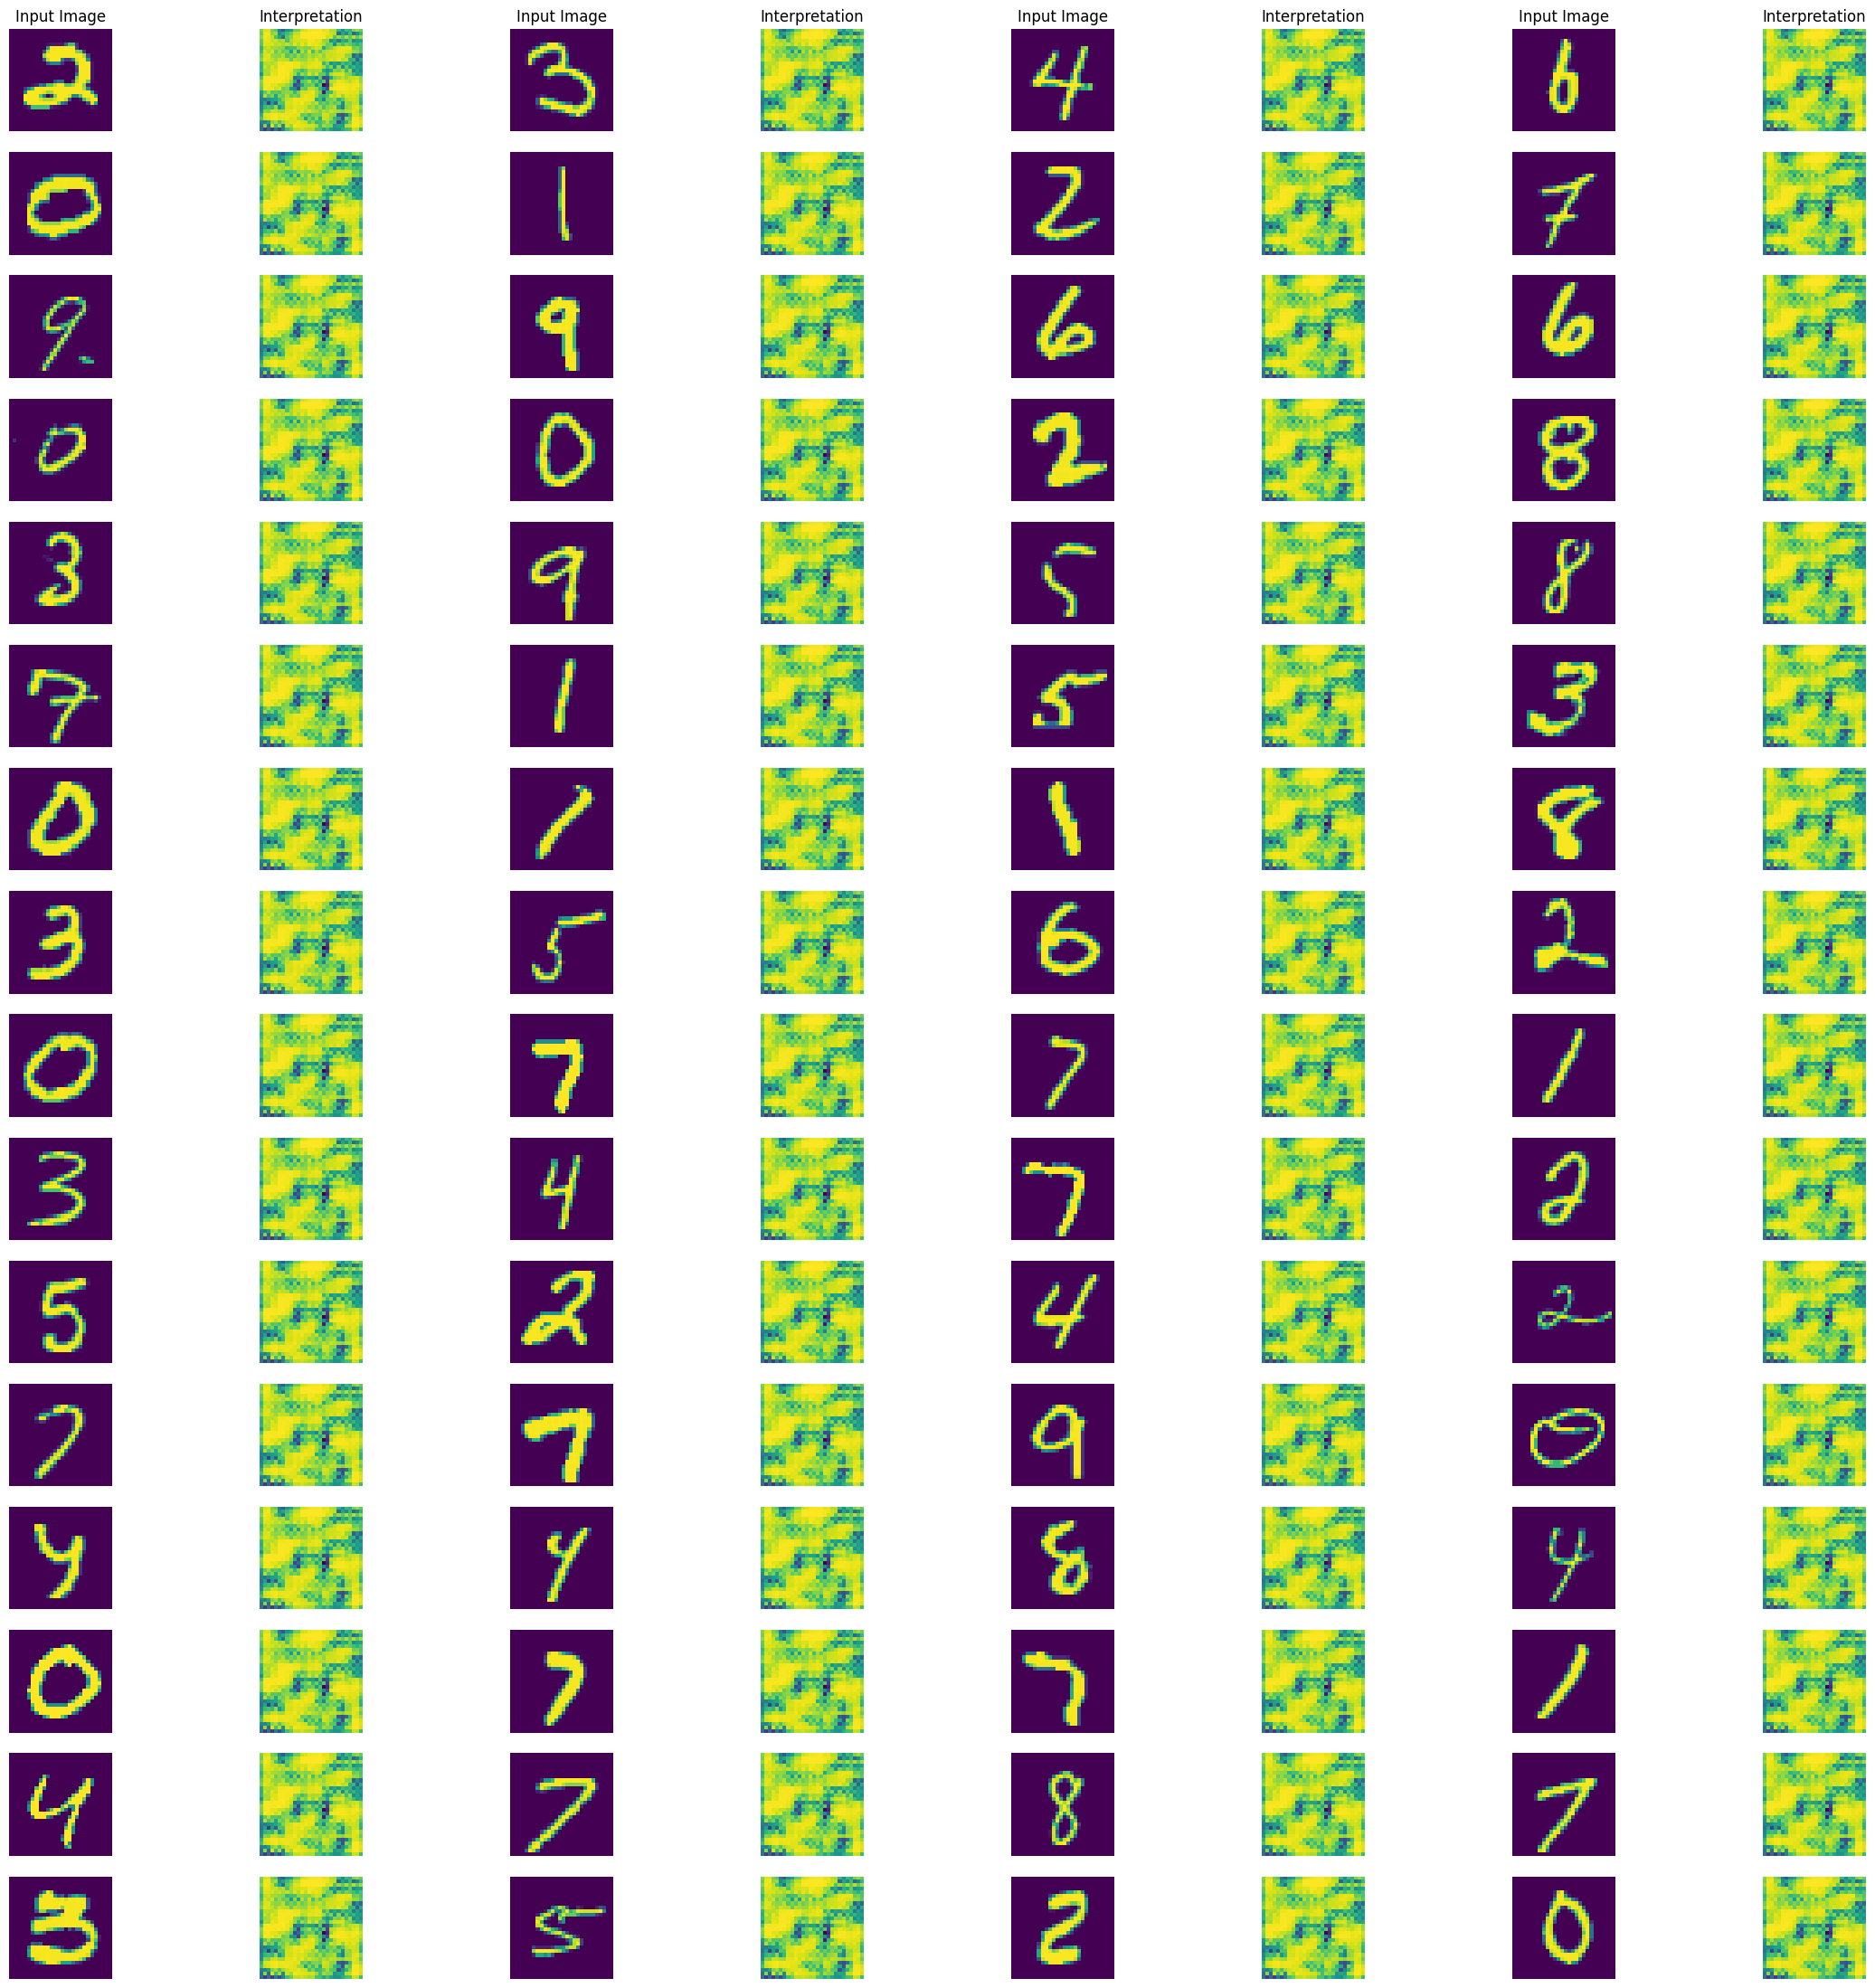

<Figure size 2000x2000 with 0 Axes>

In [4]:
import numpy as np
fig, axs = plt.subplots(16, 8, figsize=(28,28))
axs[0, 0].set_title('Input Image')
axs[0, 2].set_title('Input Image')
axs[0, 4].set_title('Input Image')
axs[0, 6].set_title('Input Image')
axs[0, 1].set_title('Interpretation')
axs[0, 3].set_title('Interpretation')
axs[0, 5].set_title('Interpretation')
axs[0, 7].set_title('Interpretation')

fig= plt.figure(figsize=(20, 20))

for j in range(0,4):
    for i in range(0,16):
        tests_figs = tests[i+j*16].reshape((28,28))
        axs[i, 2*j].imshow(tests_figs)
        axs[i, 2*j].axis('off')

        
for j in range(0,4):
    for i in range(0,16):
        interprets_figs = interprets[i+j*16].reshape((28,28))
        axs[i, 2*j+1].imshow(interprets_figs)
        axs[i, 2*j+1].axis('off')        
plt.show()